# ALeRCE check new light curve classifiers, microlensing events

```Author: Alejandra Muñoz Arancibia```

```Last updated: 251009```

ALeRCE starter notebook for microlensing event science using the new alerce client and a direct database connection.

For more information about the ALeRCE broker, please visit http://alerce.science/, or read our publications:
* The Automatic Learning for the Rapid Classification of Events (ALeRCE) Alert Broker, [Förster et al. 2021, AJ, 161, 242](https://arxiv.org/abs/2008.03303)
* Alert Classification for the ALeRCE Broker System: The Real-time Stamp Classifier, [Carrasco-Davis et al. 2021, AJ, 162, 231](https://arxiv.org/abs/2008.03309)
* Alert Classification for the ALeRCE Broker System: The Light Curve Classifier, [Sánchez-Sáez et al. 2021, AJ, 161, 141](https://arxiv.org/abs/2008.03311)

Note that this notebook uses the latest ALeRCE client, which can be installed with pip.

*It is highly recommended that you try this notebook in Google Colab using the following [link](https://colab.research.google.com/github/alercebroker/usecases/blob/master/notebooks/ALeRCE_Microlensing_Starter.ipynb).*
This will avoid you from having to sort out library installation problems and focus on the contents of the tutorial. You can try installing the dependencies later in your own system. However, note that in this notebook we use ipyaladin, which does not currently work in Google Colab.

## Requirements

Basic requirements

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
import json
import sqlalchemy as sa
import requests

The ALeRCE client

In [2]:
#!pip install alerce

In [3]:
from alerce.core import Alerce
alerce_client = Alerce()

### Some settings

In [4]:
from IPython.core.display import HTML

In [5]:
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_columns', None)

In [6]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = (6., 4.)
plt.rcParams['figure.dpi'] = 72.

### Some functions

Ancillary functions for displaying light curves and histograms

In [7]:
def ulens_model(t, u0, tE, fs, t0, mag_0):
    t = t - t0
    u = np.sqrt(u0**2 + (t / tE) ** 2)
    A = (u**2 + 2.0) / (u * np.sqrt(u**2 + 4))
    func = -2.5 * np.log10(fs * (A - 1) + 1) + mag_0
    return func

In [8]:
def ulens(times=None, params=None):
    u0 = params['ulens_u0']
    tE = params['ulens_tE']
    fs = params['ulens_fs']
    t0 = params['ulens_t0']
    mag0 = params['ulens_mag0']
    
    return ulens_model(times, u0, tE, fs, t0, mag0)

In [9]:
def magdiff2flux_uJy(df=None, col_mag=None, col_isdiffpos='isdiffpos'):
    return 10. ** (-0.4 * (df[col_mag] - 23.9)) * df[col_isdiffpos]

In [10]:
def magtot2flux_uJy(df=None, col_mag=None):
    return 10. ** (-0.4 * (df[col_mag] - 23.9))

In [11]:
def fluxerr(df=None, col_magerr=None, col_flux=None):
    return df[col_magerr].abs() * df[col_flux].abs() / 1.0857

In [12]:
def magerr(df=None, col_fluxerr=None, col_flux=None):
    return 1.0857 * df[col_fluxerr] / df[col_flux].abs()

In [13]:
def flux_epochs(df=None, col_mag=None, col_magerr=None):
    df = df.copy()
    
    df['fluxdiff_uJy'] = magdiff2flux_uJy(df=df,
                                          col_mag=col_mag)
    df['fluxerrdiff_uJy'] = fluxerr(df=df,
                                    col_magerr=col_magerr,
                                    col_flux='fluxdiff_uJy')
    
    if col_mag + '_corr' in df.columns:
        df['fluxtot_uJy'] = magtot2flux_uJy(df=df,
                                            col_mag=col_mag + '_corr')
        mask = ~df[col_magerr + '_corr_ext'].isna() & ~df[col_magerr + '_corr_ext'].isna()
        df.loc[mask, 'fluxerrtot_uJy'] = fluxerr(df=df[mask],
                                                 col_magerr=col_magerr + '_corr_ext',
                                                 col_flux='fluxtot_uJy')
        df.loc[~mask, 'fluxerrtot_uJy'] = np.nan
    
    return df

In [14]:
# From Masci+2023 sections 6.4 and 6.5
SNT = 3.
SNU = 5.

In [15]:
def flux_uJy2magupperlim(df=None, col_fluxerr=None):
    return -2.5 * np.log10(SNU * df[col_fluxerr].abs()) + 23.9

In [16]:
def flux_uJy2mag(df=None, col_flux=None):
    return -2.5 * np.log10(df[col_flux].abs()) + 23.9 # Flux in uJy

In [17]:
def plot_lc(epochs=None, use_diff=False, use_flux=False, title='',
            show_ulens=False, params_ulens=None,
            lowsnr_as_uplim=True,
            namefig=None, showfig=True):
    fids = [1, 2]#, 3]
    
    labels_ztfa = {1: 'g', 2: 'r'}
    colors_ztfa = {1: '#56E03A', 2: '#D42F4B'}
    markers_ztfa = {1: 'o', 2: 'o'}
    sizes_ztfa = {1: 30, 2: 30}
    
    labels_ztffp = {1: 'g', 2: 'r'}
    colors_ztffp = {1: 'mediumseagreen', 2: 'firebrick'}
    markers_ztffp = {1: 'o', 2: 'o'}
    sizes_ztffp = {1: 20, 2: 20}
    
    alpha_dets = 0.7
    alpha_nondets = 0.5
    alpha_forced = 0.6
    
    size_nondets = 35
    size_forced_uplim = 20

    df_dets = epochs['detections'].copy()
    df_forced = epochs['forced_photometry'].copy()
    df_nondets = epochs['non_detections'].copy()
    df_forced_uplim = pd.DataFrame()
    
    if not use_diff and 'magpsf_corr' in df_dets.columns:
        mask = (df_dets['magpsf_corr'] < 99.) \
                & (df_dets['sigmapsf_corr_ext'] < 1.)
        df_dets = df_dets[mask].copy()
        #display(df_dets)
    
    fig, ax = plt.subplots(figsize=(10, 4))
    
    col_x = 'mjd'
        
    if use_flux:
        if use_diff:
            col_y = 'fluxdiff_uJy'
            col_yerr = 'fluxerrdiff_uJy'
        else:
            col_y = 'fluxtot_uJy'
            col_yerr = 'fluxerrtot_uJy'
    else:
        if use_diff:
            col_y = 'magpsf'
            col_yerr = 'sigmapsf'
        else:
            col_y = 'magpsf_corr'
            col_yerr = 'sigmapsf_corr_ext'
    
    for fid in fids:
        mask = df_dets['fid'] == fid
        if len(df_dets[col_y][mask].notna()) > 0:
            ax.errorbar(df_dets[col_x][mask],
                        df_dets[col_y][mask],
                        yerr=df_dets[col_yerr][mask],
                        alpha=alpha_dets, c=colors_ztfa[fid],
                        linestyle='None')
            ax.scatter(df_dets[col_x][mask],
                       df_dets[col_y][mask],
                       alpha=alpha_dets,
                       s=sizes_ztfa[fid],
                       c=colors_ztfa[fid],
                       marker=markers_ztfa[fid],
                       label='%s (detection)' % labels_ztfa[fid],
                       linestyle='None')
    
    if len(df_nondets) > 0 and use_diff and not use_flux:
        for fid in fids:
            mask = df_nondets['fid'] == fid
            if len(df_nondets[mask]) > 0:
                ax.scatter(df_nondets[col_x][mask],
                           df_nondets['diffmaglim'][mask],
                           alpha=alpha_nondets,
                           s=size_nondets,
                           c=colors_ztfa[fid],
                           marker='v',
                           label='%s (non-detection)' % labels_ztfa[fid],
                           linestyle='None')
    
    if len(df_forced) > 0:
        if not use_diff and 'mag_corr' not in df_forced.columns:
            pass
        
        if use_flux:
            if use_diff:
                col_y = 'fluxdiff_uJy'
                col_yerr = 'fluxerrdiff_uJy'
            else:
                col_y = 'fluxtot_uJy'
                col_yerr = 'fluxerrtot_uJy'
        else:
            if use_diff:
                col_y = 'mag'
                col_yerr = 'e_mag'

                if lowsnr_as_uplim:
                    mask_snt = df_forced['fluxdiff_uJy'] \
                               / df_forced['fluxerrdiff_uJy'] > SNT
                
                col_fluxerr = 'fluxerrdiff_uJy'
            else:
                col_y = 'mag_corr'
                col_yerr = 'e_mag_corr_ext'

                if lowsnr_as_uplim:
                    mask_snt = df_forced['fluxtot_uJy'] \
                               / df_forced['fluxerrtot_uJy'] > SNT
                
                col_fluxerr = 'fluxerrtot_uJy'

            if lowsnr_as_uplim:
                df_forced_uplim = df_forced[~mask_snt].copy()
                df_forced_uplim[col_y + '_upperlimit'] = flux_uJy2magupperlim(df=df_forced_uplim,
                                                                              col_fluxerr=col_fluxerr)
                
                df_forced = df_forced[mask_snt].copy()
        
        for fid in fids:
            mask = df_forced['fid'] == fid
            if len(df_forced[col_y][mask].notna()) > 0:
                ax.errorbar(df_forced[col_x][mask],
                            df_forced[col_y][mask],
                            yerr=df_forced[col_yerr][mask],
                            alpha=alpha_forced, c=colors_ztffp[fid],
                            linestyle='None')
                ax.scatter(df_forced[col_x][mask],
                           df_forced[col_y][mask],
                           alpha=alpha_forced,
                           s=sizes_ztffp[fid],
                           c='none',
                           edgecolor=colors_ztffp[fid],
                           marker=markers_ztffp[fid],
                           label='%s (forced)' % labels_ztffp[fid],
                           linestyle='None')
            
        if not use_flux and len(df_forced_uplim) > 0:
            for fid in fids:
                mask = df_forced_uplim['fid'] == fid
                if len(df_forced_uplim[mask]) > 0:
                    ax.scatter(df_forced_uplim[col_x][mask],
                               df_forced_uplim[col_y + '_upperlimit'][mask],
                               alpha=alpha_forced,
                               s=size_forced_uplim,
                               c='none',
                               edgecolor=colors_ztffp[fid],
                               marker='v',
                               label='%s (forced, upper limit)' % labels_ztffp[fid],
                               linestyle='None')
    
    ax.set_xlabel('MJD')

    ulens_names = ['u0', 'tE', 'fs', 't0', 'mag0']
    ulens_names = ['ulens_' + x for x in ulens_names]
    
    if show_ulens and params_ulens is not None:
        cols = ['mjd', 'fid', 'magpsf_corr', 'sigmapsf_corr_ext']
        
        if len(df_forced) == 0:
            df_epochs = df_dets[cols].copy()
        else:
            df_forced.rename(columns={'mag_corr': 'magpsf_corr',
                                      'e_mag_corr_ext': 'sigmapsf_corr_ext'},
                             inplace=True)
            df_epochs = pd.concat([df_dets[cols], df_forced[cols]], axis=0)
        
        df_epochs.sort_values(by=['mjd'], inplace=True)
        
        mask = df_epochs['magpsf_corr'].notna() \
               & (df_epochs['sigmapsf_corr_ext'] < 1.)
        minmjd = df_epochs['mjd'][mask].min()
        
        for fid in [1, 2]:
            mask = df_epochs['fid'] == fid
            mask2 = mask & df_epochs['magpsf_corr'].notna() \
                    & (df_epochs['sigmapsf_corr_ext'] < 1.)
            if len(df_epochs[mask]) > 0:
                mjd = df_epochs['mjd'][mask].copy()
                params = dict()

                for key in ulens_names:
                    if key + '_' + str(fid) in params_ulens.keys():
                        params[key] = params_ulens[key + '_' + str(fid)]
                
                mag = pd.DataFrame(ulens(mjd - minmjd, params=params))
                mag.rename(columns={'mjd': 'magpsf_corr'}, inplace=True)
                
                if use_flux:
                    y = magtot2flux_uJy(mag, col_mag='magpsf_corr')
                    
                    ax.plot(mjd, y, c=colors_ztfa[fid], alpha=0.5,
                            label=labels_ztfa[fid] + ' (ulens)')
                else:
                    ax.plot(mjd, mag['magpsf_corr'], c=colors_ztfa[fid], alpha=0.5,
                            label=labels_ztfa[fid] + ' (ulens)')
    
    title_aux = title[:]
    
    if show_ulens and params_ulens is not None:
        title_aux += ' (ulens: chi_g=%.2e' % params_ulens['ulens_chi_1'] \
                     + ', chi_r=%.2e' % params_ulens['ulens_chi_2'] + ')'
    
    ax.set_title(title_aux)
    
    if use_flux:
        if use_diff:
            ax.set_ylabel('Difference Flux [uJy]')
        else:
            ax.set_ylabel('Total Flux [uJy]')
    else:
        if use_diff:
            ax.set_ylabel('Difference Magnitude')
            ax.set_ylim(ax.get_ylim()[::-1])
        else:
            ax.set_ylabel('Apparent Magnitude')
            ax.set_ylim(ax.get_ylim()[::-1])
    
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    if namefig is not None:
        plt.tight_layout()
        fig.savefig(namefig)

    if not showfig:
        plt.close(fig)

In [18]:
def plot_cols_hist(df=None, cols=None, bins=None, xlims=None,
                   title=None, fontsize=None, namefig=None, showfig=True):
    alpha = 0.7
    
    if fontsize is not None:
        plt.rcParams.update({'font.size': fontsize})
    
    for col in cols:
        fig, ax = plt.subplots(figsize=(8, 4))
        ax.hist(df[col], bins=bins, range=xlims, alpha=alpha)
        ax.set_xlabel(col)
        ax.set_ylabel('Frequency')
        ax.set_yscale('log')
        ax.set_title(title)
        
        if namefig is not None:
            plt.tight_layout()
            fig.savefig(namefig)
    
    if fontsize is not None:
        plt.rcParams.update({'font.size': 12})
    
    if not showfig:
        plt.close(fig)

## Query microlensing events using the ALeRCE client and a direct database connection

### For a known microlensing event, query and display its light curve and features

First, we define manually the oid that we want to explore

In [19]:
oid = 'ZTF25aajjjlb'

Create a link to the ALeRCE Explorer for this object. The following function accepts lists of objects too (it works up to a maximum of 200 objects)

In [20]:
def print_link(index=None, classifier='stamp_classifier'):
    if len(index) == 1:
        expr = 'https://alerce.online/object/' + index[0]
    else:
        expr1 = 'https://alerce.online/?oid='
        expr2 = '&oid='.join(list(index))
        expr3 = '&selectedClassifier=' + classifier + '&page=1'
        expr = expr1 + expr2 + expr3
    
    display(HTML("<a href='%s' target=\"_blank\"> %s <a>" % (expr, expr)))

In [21]:
print_link(index=[oid])

We define a function to query the object light curve using the ALeRCE client

In [22]:
def find_epochs(oid=None,
                names=['detections',
                       'forced_photometry',
                       'non_detections']):
    df_dets = pd.DataFrame()
    df_forced = pd.DataFrame()
    df_nondets = pd.DataFrame()
    
    if 'detections' in names:
        df_dets = alerce_client.query_detections(oid, format='pandas')
        df_dets['oid'] = oid
        df_dets.set_index('oid', inplace=True)
        df_dets.sort_values(by='mjd', inplace=True)
        df_dets = flux_epochs(df_dets, col_mag='magpsf', col_magerr='sigmapsf')

    if 'forced_photometry' in names:
        df_forced = alerce_client.query_forced_photometry(oid, format='pandas')
        if len(df_forced) > 0:
            df_forced.set_index('oid', inplace=True)
            df_dets.sort_values(by='mjd', inplace=True)
            df_forced = flux_epochs(df_forced, col_mag='mag', col_magerr='e_mag')

    if 'non_detections' in names:
        df_nondets = alerce_client.query_non_detections(oid, format='pandas')
        if len(df_nondets) > 0:
            df_nondets['oid'] = oid
            df_nondets.set_index('oid', inplace=True)
            df_nondets.sort_values(by='mjd', inplace=True)

    epochs = {'detections': df_dets,
              'forced_photometry': df_forced,
              'non_detections': df_nondets}

    return epochs

In [23]:
epochs = find_epochs(oid=oid,
                     names=['detections',
                            'forced_photometry'])#,
                            #'non_detections'])

We display pandas dataframes for the object detections and forced photometry epochs

In [24]:
for key in epochs.keys():
    print(key)
    display(epochs[key])

detections


,tid,mjd,candid,fid,pid,diffmaglim,isdiffpos,nid,distnr,magpsf,magpsf_corr,magap,sigmapsf,sigmapsf_corr,sigmapsf_corr_ext,sigmagap,ra,dec,rb,rbversion,drb,magapbig,sigmagapbig,rfid,has_stamp,corrected,dubious,step_id_corr,phase,parent_candid,fluxdiff_uJy,fluxerrdiff_uJy,fluxtot_uJy,fluxerrtot_uJy
oid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ZTF25aajjjlb,ztf,60756.298310,3002298311715015006,2,3002298311715,20.291126,1,3002,0.562929,19.663721,17.534374,20.1610,0.189004,0.022760,0.026591,0.3631,140.163858,75.795004,0.850000,t17_f5_c3,0.998838,20.0146,0.4030,859120217.0,True,True,False,27.5.0,0.0,NaN,49.489333,8.615349,351.763197,8.615355
ZTF25aajjjlb,ztf,60758.258160,3004258151715015009,1,3004258151715,20.314400,1,3004,0.645830,20.182400,18.308228,20.0163,0.247621,0.041509,0.044068,0.2935,140.163503,75.794968,0.931429,t17_f5_c3,NaN,19.7736,0.2997,NaN,False,True,False,27.5.6,0.0,3.032303e+18,30.693047,7.000316,172.468108,7.000314
ZTF25aajjjlb,ztf,60758.320706,3004320701715015011,2,3004320701715,20.296259,1,3004,0.514697,19.583470,17.522718,19.5681,0.155133,0.018855,0.023249,0.2107,140.163479,75.795029,0.895714,t17_f5_c3,0.999939,19.5012,0.2514,859120217.0,True,True,False,27.5.0,0.0,NaN,53.285863,7.613867,355.559920,7.613880
ZTF25aajjjlb,ztf,60760.245324,3006245321715015017,1,3006245321715,20.558130,1,3006,0.381928,19.892265,18.250595,19.7775,0.170369,0.034840,0.037560,0.1995,140.163944,75.795042,0.934286,t17_f5_c3,0.999998,19.7406,0.2450,859120117.0,True,True,False,27.5.2,0.0,NaN,40.095349,6.291811,181.870391,6.291807
ZTF25aajjjlb,ztf,60770.286088,3016286081715015005,2,3016286081715,19.928053,1,3016,0.280600,18.573374,17.297873,18.6692,0.124984,0.036988,0.038606,0.1317,140.163758,75.795078,0.940000,t17_f5_c3,0.999994,18.5255,0.1471,859120217.0,True,True,False,27.5.4,0.0,NaN,135.098460,15.552280,437.371822,15.552274
ZTF25aajjjlb,ztf,60772.270451,3018270451715015007,1,3018270451715,19.649660,1,3018,0.124103,18.694614,17.851767,18.5566,0.117627,0.053242,0.054121,0.1428,140.163750,75.795104,0.961429,t17_f5_c3,0.999998,18.3427,0.1501,859120117.0,True,True,False,27.5.4,0.0,NaN,120.824331,13.090395,262.599080,13.090373
ZTF25aajjjlb,ztf,60772.286215,3018286211715015003,2,3018286211715,19.799511,1,3018,0.374490,18.451115,17.258617,18.3757,0.075255,0.022713,0.025092,0.1153,140.163817,75.795056,0.955714,t17_f5_c3,0.999971,18.2905,0.1361,859120217.0,True,True,False,27.5.4,0.0,NaN,151.200769,10.480373,453.474844,10.480385
ZTF25aajjjlb,ztf,60774.323912,3020323911715015004,2,3020323911715,19.658566,1,3020,0.247172,18.301481,17.206400,18.3873,0.080553,0.027566,0.029380,0.1200,140.163727,75.795090,0.960000,t17_f5_c3,1.000000,18.3863,0.1531,859120217.0,True,True,False,27.5.4,0.0,NaN,173.543200,12.875989,475.817050,12.875995
ZTF25aajjjlb,ztf,60774.361875,3020361871715015004,1,3020361871715,19.366047,1,3020,0.201880,18.551920,17.783775,18.6013,0.106996,0.051940,0.052736,0.1727,140.163770,75.795082,0.954286,t17_f5_c3,0.999994,18.5504,0.2112,859120117.0,True,True,False,27.5.4,0.0,NaN,137.794537,13.579658,279.569635,13.579657


forced_photometry


,candid,tid,pid,mjd,fid,ra,e_ra,dec,e_dec,mag,e_mag,mag_corr,e_mag_corr,e_mag_corr_ext,isdiffpos,corrected,dubious,parent_candid,has_stamp,scibckgnd,exptime,magnr,scisigpix,adpctdif1,sigmagnr,magzpsci,adpctdif2,chinr,diffmaglim,programid,sharpnr,field,magzpsciunc,procstatus,rcid,magzpscirms,distnr,rfid,clrcoeff,ranr,sciinpseeing,clrcounc,decnr,fluxdiff_uJy,fluxerrdiff_uJy,fluxtot_uJy,fluxerrtot_uJy
oid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ZTF25aajjjlb,ZTF25aajjjlb3000364951715,ztf,3000364951715,60754.364954,2,140.163729,None,75.795096,None,19.783949,0.101949,17.550506,100.000000,0.013032,1,True,False,3027354441715015023,False,270.673004,30.0,17.698999,9.22391,0.078285,0.016,26.202299,0.084058,0.813,20.133101,1,-0.002,859,0.000011,0,17,0.029318,0.225482,859120217,0.113839,140.163742,1.5502,0.000016,75.795158,44.301705,4.159999,346.575319,4.159999
ZTF25aajjjlb,ZTF25aajjjlb2990282021715,ztf,2990282021715,60744.282026,2,140.163817,None,75.795056,None,20.191406,0.232539,17.594825,0.015534,0.021275,1,True,False,3018286211715015003,False,282.221985,30.0,17.698999,11.46080,0.083450,0.016,26.242399,0.081391,0.813,19.657101,1,-0.002,859,0.000011,0,17,0.029798,0.379096,859120217,0.110267,140.163742,2.3258,0.000017,75.795158,30.439499,6.519637,332.713113,6.519637
ZTF25aajjjlb,ZTF25aajjjlb2972350931715,ztf,2972350931715,60726.350938,1,140.163858,None,75.795004,None,23.465223,2.031526,18.509630,0.011428,0.021163,1,True,False,3002298311715015006,False,133.018997,30.0,18.521000,6.16792,0.081231,0.018,26.244699,0.078722,0.675,20.489799,1,-0.024,859,0.000012,0,17,0.030629,0.495126,859120117,-0.078211,140.163757,2.0061,0.000018,75.795135,1.492487,2.792693,143.267612,2.792693
ZTF25aajjjlb,ZTF25aajjjlb2972310311715,ztf,2972310311715,60726.310313,2,140.163858,None,75.795004,None,20.315228,0.158386,17.605585,100.000000,0.013057,1,True,False,3002298311715015006,False,283.041992,30.0,17.698999,6.87942,0.084713,0.016,26.235800,0.086414,0.813,20.180700,1,-0.002,859,0.000008,0,17,0.024830,0.570218,859120217,0.119591,140.163742,2.8487,0.000012,75.795158,27.158701,3.962007,329.432315,3.962007
ZTF25aajjjlb,ZTF25aajjjlb3004258151715,ztf,3004258151715,60758.258160,1,140.163479,None,75.795029,None,20.179401,0.116814,18.307693,0.014677,0.020836,1,True,False,3004320701715015011,False,132.445007,30.0,18.521000,6.97767,0.084022,0.018,26.232401,0.081331,0.675,20.314400,1,-0.024,859,0.000011,0,17,0.029569,0.463168,859120117,-0.064193,140.163757,2.0594,0.000017,75.795135,30.777932,3.311495,172.553057,3.311495
ZTF25aajjjlb,ZTF25aajjjlb2985302111715,ztf,2985302111715,60739.302118,1,140.163944,None,75.795042,None,20.774570,0.231873,18.392656,0.020310,0.025851,1,True,False,3006245321715015017,False,133.910995,30.0,18.521000,6.73763,0.081911,0.018,26.266199,0.080289,0.675,20.234200,1,-0.024,859,0.000013,0,17,0.032333,0.386054,859120117,-0.084464,140.163757,2.4042,0.000020,75.795135,17.789831,3.799381,159.564955,3.799381
ZTF25aajjjlb,ZTF25aajjjlb2980327651715,ztf,2980327651715,60734.327650,2,140.163944,None,75.795042,None,20.736109,0.356522,17.634736,0.013871,0.020490,1,True,False,3006245321715015017,False,242.947006,30.0,17.698999,8.88849,0.100219,0.016,26.084801,0.100677,0.813,19.555300,1,-0.002,859,0.000018,0,17,0.038217,0.458937,859120217,0.117627,140.163742,2.9341,0.000028,75.795158,18.431322,6.052470,320.704936,6.052470
ZTF25aajjjlb,ZTF25aajjjlb3018270451715,ztf,3018270451715,60772.270451,1,140.163817,None,75.795056,None,18.706303,0.059831,17.857128,0.025567,0.027369,1,True,False,3018286211715015003,False,121.241997,30.0,18.521000,11.80500,0.089295,0.018,26.136600,0.078044,0.675,19.649700,1,-0.024,859,0.000018,0,17,0.036478,0.304004,859120117,-0.051936,140.163757,2.0070,0.000033,75.795135,119.530557,6.587121,261.305681,6.587121
ZTF25aajjjlb,ZTF25aajjjlb3016286081715,ztf,3016286081715,60770.286088,2,140.163817,None,75.795056,None,18.514414,0.037880,17.279316,0.005414,0.012144,1,True,False,3018286211715015003,False,259.472992,30.0,17.698999,10.32870,0.082239,

non_detections


""


We query all features available for this object using the ALeRCE client

In [25]:
features_all = alerce_client.query_features(oid, format='pandas')

In [26]:
features_all

,name,value,fid,version
0,g-r_mean,0.363114,12,27.5.4
1,g-r_max,0.284872,12,27.5.4
2,g-r_mean_corr,0.654637,12,27.5.4
3,g-r_max_corr,0.572508,12,27.5.4
4,W1-W2,0.174000,0,27.5.4
...,...,...,...,...
1009,mean_chinr,0.759923,12,27.5.2
1010,Timespan,3.946802,0,27.5.2
1011,Coordinate_x,-0.188431,0,27.5.2
1012,Coordinate_y,0.157197,0,27.5.2


We select only the latest version (as it is the one used by the ALeRCE light curve classifiers that include forced photometry data)

In [27]:
feature_version = '27.5.6' # Latest version by June 9 2025

In [28]:
mask = features_all['version'] == feature_version
features = features_all[mask].copy()

In [29]:
features

,name,value,fid,version
380,g-r_mean,0.212987,12,27.5.6
381,g-r_max,0.064774,12,27.5.6
382,g-r_mean_corr,0.581760,12,27.5.6
383,g-r_max_corr,0.396854,12,27.5.6
384,W1-W2,0.174000,0,27.5.6
...,...,...,...,...
591,Skew,-0.062475,2,27.5.6
592,SmallKurtosis,-0.785967,2,27.5.6
593,Std,0.174189,2,27.5.6
594,StetsonK,0.862500,2,27.5.6


We pivot this dataframe to make the features appear as columns

In [30]:
df_features = features.copy()
df_features['oid'] = oid
df_features['fname'] = df_features['name'] + '_' + df_features['fid'].astype(str)
df_features = df_features.pivot_table(index='oid', columns='fname', values='value', dropna=False)

In [31]:
df_features

fname,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,Con_1,Con_2,Coordinate_x_0,Coordinate_y_0,Coordinate_z_0,Eta_e_1,Eta_e_2,ExcessVar_1,ExcessVar_2,GP_DRW_sigma_1,GP_DRW_sigma_2,GP_DRW_tau_1,GP_DRW_tau_2,Gskew_1,Gskew_2,Harmonics_chi_1,Harmonics_chi_2,Harmonics_mag_1_1,Harmonics_mag_1_2,Harmonics_mag_2_1,Harmonics_mag_2_2,Harmonics_mag_3_1,Harmonics_mag_3_2,Harmonics_mag_4_1,Harmonics_mag_4_2,Harmonics_mag_5_1,Harmonics_mag_5_2,Harmonics_mag_6_1,Harmonics_mag_6_2,Harmonics_mag_7_1,Harmonics_mag_7_2,Harmonics_mse_1,Harmonics_mse_2,Harmonics_phase_2_1,Harmonics_phase_2_2,Harmonics_phase_3_1,Harmonics_phase_3_2,Harmonics_phase_4_1,Harmonics_phase_4_2,Harmonics_phase_5_1,Harmonics_phase_5_2,Harmonics_phase_6_1,Harmonics_phase_6_2,Harmonics_phase_7_1,Harmonics_phase_7_2,IAR_phi_1,IAR_phi_2,LinearTrend_1,LinearTrend_2,MHPS_PN_flag_1,MHPS_PN_flag_2,MHPS_high_1,MHPS_high_2,MHPS_high_30_1,MHPS_high_30_2,MHPS_low_1,MHPS_low_2,MHPS_low_365_1,MHPS_low_365_2,MHPS_non_zero_1,MHPS_non_zero_2,MHPS_ratio_1,MHPS_ratio_2,MHPS_ratio_365_30_1,MHPS_ratio_365_30_2,MaxSlope_1,MaxSlope_2,Mean_1,Mean_2,Meanvariance_1,Meanvariance_2,MedianAbsDev_1,MedianAbsDev_2,MedianBRP_1,MedianBRP_2,Multiband_period_12,PPE_12,PairSlopeTrend_1,PairSlopeTrend_2,PercentAmplitude_1,PercentAmplitude_2,Period_band_1,Period_band_2,Power_rate_1/2_12,Power_rate_1/3_12,Power_rate_1/4_12,Power_rate_2_12,Power_rate_3_12,Power_rate_4_12,Psi_CS_1,Psi_CS_2,Psi_eta_1,Psi_eta_2,Pvar_1,Pvar_2,Q31_1,Q31_2,Rcs_1,Rcs_2,SF_ML_amplitude_1,SF_ML_amplitude_2,SF_ML_gamma_1,SF_ML_gamma_2,SPM_A_1,SPM_A_2,SPM_beta_1,SPM_beta_2,SPM_chi_1,SPM_chi_2,SPM_gamma_1,SPM_gamma_2,SPM_t0_1,SPM_t0_2,SPM_tau_fall_1,SPM_tau_fall_2,SPM_tau_rise_1,SPM_tau_rise_2,Skew_1,Skew_2,SmallKurtosis_1,SmallKurtosis_2,Std_1,Std_2,StetsonK_1,StetsonK_2,TDE_decay_1,TDE_decay_2,TDE_decay_chi_1,TDE_decay_chi_2,TDE_mag0_1,TDE_mag0_2,Timespan_0,W1-W2_0,W2-W3_0,W3-W4_0,color_variation_12,dbrightness_first_det_band_1,dbrightness_first_det_band_2,dbrightness_forced_phot_band_1,dbrightness_forced_phot_band_2,delta_period_1,delta_period_2,distpsnr1_0,fleet_a_1,fleet_a_2,fleet_chi_1,fleet_chi_2,fleet_m0_1,fleet_m0_2,fleet_t0_1,fleet_t0_2,fleet_w_1,fleet_w_2,g-W1_0,g-W2_0,g-W3_0,g-W4_0,g-r_max_12,g-r_max_corr_12,g-r_mean_12,g-r_mean_corr_12,last_brightness_before_band_1,last_brightness_before_band_2,max_brightness_after_band_1,max_brightness_after_band_2,max_brightness_before_band_1,max_brightness_before_band_2,mean_chinr_12,mean_distnr_12,mean_sharpnr_12,median_brightness_after_band_1,median_brightness_after_band_2,median_brightness_before_band_1,median_brightness_before_band_2,n_forced_phot_band_after_1,n_forced_phot_band_after_2,n_forced_phot_band_before_1,n_forced_phot_band_before_2,positive_fraction_1,positive_fraction_2,ps_g-r_0,ps_i-z_0,ps_r-i_0,r-W1_0,r-W2_0,r-W3_0,r-W4_0,sgscore1_0,sigma_distnr_12,ulens_chi_1,ulens_chi_2,ulens_fs_1,ulens_fs_2,ulens_mag0_1,ulens_mag0_2,ulens_t0_1,ulens_t0_2,ulens_tE_1,ulens_tE_2,ulens_u0_1,ulens_u0_2
oid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ZTF25aajjjlb,0.456223,0.267723,0.590532,0.331224,2.0,2.0,0.4,0.416667,0.0,0.0,-0.18843,0.157196,0.969424,0.164076,0.135547,0.000217,0.000099,4297.622112,6438.734497,16.556503,24.173612,0.127317,-0.023188,0.014981,0.107481,3.047002,0.230686,1.054189,0.176265,1.691464,0.173139,3.025,0.234523,3.175684,0.185596,1.926009,0.140538,0.586848,0.062117,0.000014,0.000083,3.320048,2.861262,2.453156,2.540694,5.575701,2.706391,2.338855,2.297818,5.36219,2.256608,2.068548,2.258234,0.950992,0.9542,-0.012463,-0.00157,0.0,0.0,0.262057,0.0608,1.837446,2.583292,2.153373,2.057053,0.077031,0.083218,10.0,13.0,8.2172,33.833111,0.041923,0.032214,0.062037,0.040774,17.846493,17.286883,0.014994,0.010076,0.126038,0.142588,0.5,0.166667,80.627374

Show feature names

In [32]:
cols_features = [x for x in df_features.columns]

In [33]:
cols_features

['Amplitude_1',
 'Amplitude_2',
 'AndersonDarling_1',
 'AndersonDarling_2',
 'Autocor_length_1',
 'Autocor_length_2',
 'Beyond1Std_1',
 'Beyond1Std_2',
 'Con_1',
 'Con_2',
 'Coordinate_x_0',
 'Coordinate_y_0',
 'Coordinate_z_0',
 'Eta_e_1',
 'Eta_e_2',
 'ExcessVar_1',
 'ExcessVar_2',
 'GP_DRW_sigma_1',
 'GP_DRW_sigma_2',
 'GP_DRW_tau_1',
 'GP_DRW_tau_2',
 'Gskew_1',
 'Gskew_2',
 'Harmonics_chi_1',
 'Harmonics_chi_2',
 'Harmonics_mag_1_1',
 'Harmonics_mag_1_2',
 'Harmonics_mag_2_1',
 'Harmonics_mag_2_2',
 'Harmonics_mag_3_1',
 'Harmonics_mag_3_2',
 'Harmonics_mag_4_1',
 'Harmonics_mag_4_2',
 'Harmonics_mag_5_1',
 'Harmonics_mag_5_2',
 'Harmonics_mag_6_1',
 'Harmonics_mag_6_2',
 'Harmonics_mag_7_1',
 'Harmonics_mag_7_2',
 'Harmonics_mse_1',
 'Harmonics_mse_2',
 'Harmonics_phase_2_1',
 'Harmonics_phase_2_2',
 'Harmonics_phase_3_1',
 'Harmonics_phase_3_2',
 'Harmonics_phase_4_1',
 'Harmonics_phase_4_2',
 'Harmonics_phase_5_1',
 'Harmonics_phase_5_2',
 'Harmonics_phase_6_1',
 'Harmonics_pha

Show only feature names for the microlensing model used by ALeRCE, which is based on Khakpash et al. (2021, AJ, 161, 132)

In [34]:
cols_ulens = df_features.columns[df_features.columns.str.contains('ulens')].tolist()

In [35]:
cols_ulens

['ulens_chi_1',
 'ulens_chi_2',
 'ulens_fs_1',
 'ulens_fs_2',
 'ulens_mag0_1',
 'ulens_mag0_2',
 'ulens_t0_1',
 'ulens_t0_2',
 'ulens_tE_1',
 'ulens_tE_2',
 'ulens_u0_1',
 'ulens_u0_2']

In [36]:
df_features[cols_ulens]

fname,ulens_chi_1,ulens_chi_2,ulens_fs_1,ulens_fs_2,ulens_mag0_1,ulens_mag0_2,ulens_t0_1,ulens_t0_2,ulens_tE_1,ulens_tE_2,ulens_u0_1,ulens_u0_2
oid,,,,,,,,,,,,
ZTF25aajjjlb,0.465499,0.334326,0.496314,0.578683,18.530158,17.63216,55.783939,55.889537,30.806623,19.90491,0.236453,0.445207


We define a function that plots the light curve and microlensing model for a given object

In [37]:
def plot_lc_oid(oid=None,
                show_params=False,
                show_epochs=False,
                features=None,
                brightness_types=['difference flux',
                                  'difference magnitude',
                                  'total flux',
                                  'apparent magnitude']):
    print(oid)
    print_link(index=[oid], classifier='stamp_classifier')
    epochs = find_epochs(oid=oid,
                         names=['detections',
                                'forced_photometry'])#,
                                #'non_detections'])
    
    print(str(len(epochs['detections'])) + ' detections')
    print(str(len(epochs['forced_photometry'])) + ' forced photometry epochs')
    #print(str(len(epochs['non_detections'])) + ' non-detections')

    if features is not None:
        ulens_this = features.loc[[oid], cols_ulens].T.copy()
        ulens_this.columns = ['value']
        ulens_this = {key: val for (key, val) in zip(ulens_this.index,
                                                     ulens_this['value'])}
        if show_params:
            display(ulens_this)
    if show_epochs:
        display(epochs['detections'])
        display(epochs['forced_photometry'])
        display(epochs['non_detections'])

    name = 'apparent magnitude'
    if name in brightness_types:
        plot_lc(epochs=epochs, title=oid + ', ' + name,
                show_ulens=True, params_ulens=ulens_this)#, lowsnr_as_uplim=False)
    name = 'total flux'
    if name in brightness_types:
        plot_lc(epochs=epochs, title=oid + ', ' + name,
                show_ulens=True, params_ulens=ulens_this, use_flux=True)
    name = 'difference magnitude'
    if name in brightness_types:
        plot_lc(epochs=epochs, title=oid + ', ' + name,
                use_diff=True)#, lowsnr_as_uplim=False)
    name = 'difference flux'
    if name in brightness_types:
        plot_lc(epochs=epochs, title=oid + ', ' + name,
                use_diff=True, use_flux=True)

We plot the light curve for the object, using four different types for the brightness. Apparent magnitudes and total fluxes include the contribution of the reference object (if any)

ZTF25aajjjlb


23 detections
21 forced photometry epochs


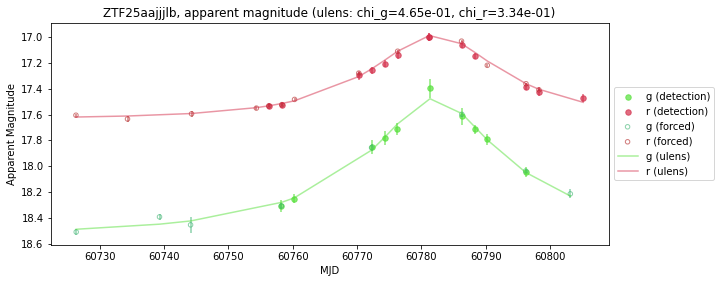

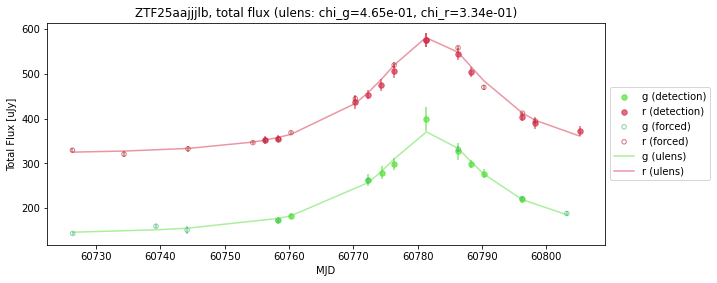

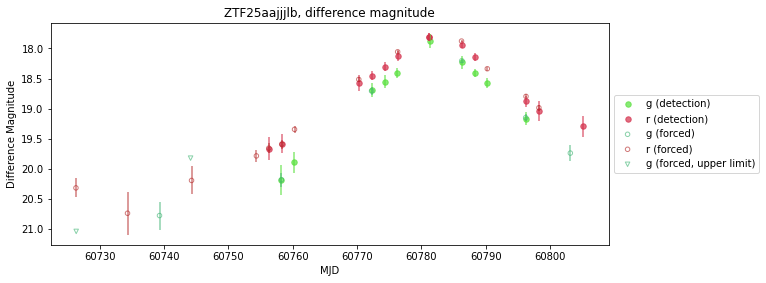

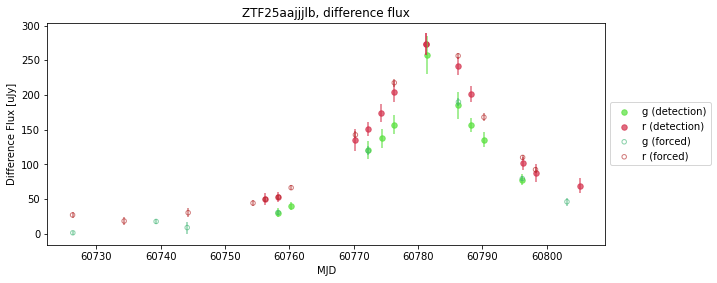

In [38]:
brightness_types = [
    'apparent magnitude',
    'total flux',
    'difference magnitude',
    'difference flux',
]

plot_lc_oid(
    oid=oid,
    features=df_features,
    brightness_types=brightness_types,
)

### New classifiers: names, versions, taxonomy

Details for the ALeRCE new light curve classifiers and features, which include ZTF forced photometry data, will be introduced in a forthcoming paper (Cabrera-Vives et al., in preparation).

In [39]:
classifier_names = [
    'lc_classifier_BHRF_forced_phot',
    'LC_classifier_ATAT_forced_phot(beta)',
]

# Latest classifier versions (probability table)
classifier_versions = ['2.1.0', '1.1.0_beta']

# Latest feature version (feature table), it is used for these classifiers
feature_versions = ['27.5.6']

# Taxonomy for new classifiers
cls_sort = ['SNIa', 'SESN', 'SNII', 'SNIIn', 'SLSN', 'TDE',
            'Microlensing', 'QSO', 'AGN', 'Blazar', 'YSO', 'CV/Nova',
            'LPV', 'EA', 'EB/EW', 'Periodic-Other', 'RSCVn', 'CEP', 'RRLab', 'RRLc', 'DSCT']

### Query probabilities for lc_classifier_BHRF_forced_phot

#### Connect to the ALeRCE DB

In [40]:
credentials_url = 'https://raw.githubusercontent.com/alercebroker/usecases/master/alercereaduser_v4.json'
params = requests.get(credentials_url).json()['params']

In [41]:
engine = sa.create_engine('postgresql+psycopg2://' + params['user'] \
                          + ':' + params['password'] + '@' + params['host'] \
                          + '/' + params['dbname'])
conn = engine.connect()

#### Query recent objects

New classifiers started on May 29 2025 (lc_classifier_BHRF_forced_phot) and June 3 2025 (LC_classifier_ATAT_forced_phot(beta)). Given the 2min timeout for public users, this query to the object table is useful before querying the probability table, specially for classifiers in beta mode. Note that light curve classifiers in a beta stage lack some indices (ranking and probability) in the probability table, making some queries very slow.

In this query, we select objects that had their first ZTF detection on or after Apr 1 2025, and have at least 8 detections (irrespective of band).

In [42]:
firstmjd_min = Time('2025-04-01T00:00:00', format='isot', scale='utc').mjd
print(firstmjd_min)

60766.0


In [43]:
ndet_min = 8

query = '''
SELECT
    oid, ndet, meanra, meandec,
    firstmjd, lastmjd, deltajd
FROM
    object
WHERE
    ndet >= %d
    AND firstmjd > %g
''' % (ndet_min, firstmjd_min)
#print(query)

df_recent = pd.read_sql_query(query, conn)
df_recent.set_index('oid', inplace=True)
display(df_recent)

,ndet,meanra,meandec,firstmjd,lastmjd,deltajd
oid,,,,,,
ZTF25aaylzzh,11,284.488939,13.193313,60832.413843,60859.354109,26.940266
ZTF22aagqkmh,8,302.358879,15.425476,60826.441690,60855.360995,28.919306
ZTF25aaymasj,9,309.398985,58.952195,60831.348461,60855.388634,24.040174
ZTF25abweajr,12,71.573295,23.000010,60927.434792,60956.406528,28.971736
ZTF18acfutoq,13,357.264334,51.326400,60847.347870,60941.249919,93.902049
...,...,...,...,...,...,...
ZTF25abwdnkv,8,86.690616,21.012984,60929.403611,60956.320752,26.917141
ZTF22abuellf,12,80.920818,21.313795,60927.504502,60956.319815,28.815312
ZTF17aaaruyi,9,74.210838,37.950987,60929.408831,60956.322164,26.913333


#### Query ranking=1 probabilities in lc_classifier_BHRF_forced_phot for these objects

Note that objects that have less than 8 detections with rb>=0.55 will not have classifications

In [44]:
i = 0
clf_name = classifier_names[i]
clf_version = classifier_versions[i]
cl_this = 'Microlensing'

In [45]:
def query_probs_r1(chunk_size=3000, oids=None,
                   clf_name='lc_classifier_BHRF_forced_phot',
                   clf_version='2.1.0', cl='Microlensing'):
    bin_ids = np.arange(int(np.ceil(len(oids) / chunk_size)))
    print(str(len(bin_ids)) + ' chunks')

    df_probs = pd.DataFrame()
    
    for idx in bin_ids:
        print('Chunk ' + str(idx))
        
        index_i = idx * chunk_size
        if idx == bin_ids[-1]:
            index_f = len(oids)
        else:
            index_f = (idx + 1) * chunk_size
        
        if index_i == index_f:
            continue

        names = np.array(oids)[index_i:index_f].tolist()
        #print(names)
        
        query = '''
        SELECT
            oid, class_name, probability, ranking
        FROM
            probability
        WHERE
            oid IN (%s)
            AND classifier_name = '%s'
            AND classifier_version = '%s'
            AND ranking = 1
            AND class_name = '%s'
        ''' % (','.join(["'%s'" % oid for oid in names]),
               clf_name, clf_version, cl)
        
        df_aux = pd.read_sql_query(query, conn)
        df_probs = pd.concat([df_probs, df_aux], axis=0)
        del df_aux

    return df_probs

In [46]:
print(clf_name, clf_version)

# Loop of queries
df_probs_r1_ulens = query_probs_r1(chunk_size=10000,
                                   oids=df_recent.index,
                                   clf_name=clf_name,
                                   clf_version=clf_version,
                                   cl=cl_this)
df_probs_r1_ulens.set_index('oid', inplace=True)
display(df_probs_r1_ulens)

lc_classifier_BHRF_forced_phot 2.1.0
4 chunks
Chunk 0
Chunk 1
Chunk 2
Chunk 3


,class_name,probability,ranking
oid,,,
ZTF18abgwqjj,Microlensing,0.237272,1
ZTF18acsmowq,Microlensing,0.206592,1
ZTF18adccmni,Microlensing,0.161700,1
ZTF18adfhbfo,Microlensing,0.136784,1
ZTF18adjucld,Microlensing,0.250980,1
...,...,...,...
ZTF25abscxgw,Microlensing,0.111720,1
ZTF25absiqcu,Microlensing,0.308124,1
ZTF25abstdlv,Microlensing,0.217952,1


In [47]:
df_probs_r1_ulens.sort_values(by='probability',
                              ascending=False,
                              inplace=True)

Show an ALeRCE Explorer link for these objects, sort by probability

In [48]:
print(clf_name, clf_version, cl_this)
print(str(len(df_probs_r1_ulens)) + ' rows')

if len(df_probs_r1_ulens) > 0:
    print_link(index=df_probs_r1_ulens.iloc[0:200].index,
               classifier='stamp_classifier')
    display(df_probs_r1_ulens)#.iloc[0:10])

lc_classifier_BHRF_forced_phot 2.1.0 Microlensing
824 rows


,class_name,probability,ranking
oid,,,
ZTF25aawljhn,Microlensing,0.543312,1
ZTF25aaraqre,Microlensing,0.540548,1
ZTF25aargdhd,Microlensing,0.500136,1
ZTF25abdkslq,Microlensing,0.489984,1
ZTF25abdkipp,Microlensing,0.482052,1
...,...,...,...
ZTF25aayhkrx,Microlensing,0.104120,1
ZTF25aalxjke,Microlensing,0.095584,1
ZTF25aazhwxh,Microlensing,0.094536,1


#### Show distribution of probabilities

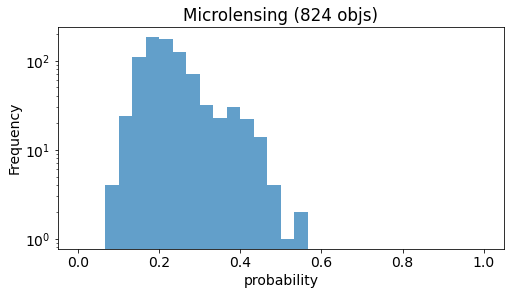

In [49]:
prop = 'probability'
title = cl_this + ' (' + str(len(df_probs_r1_ulens)) + ' objs)'
plot_cols_hist(df=df_probs_r1_ulens, cols=[prop], bins=30, xlims=[0., 1.],
               title=title, fontsize=14)

#### Query features for this objects and a given feature version

In [50]:
def query_features(chunk_size=3000, oids=None,
                   ft_versions=['27.5.6']):
    bin_ids = np.arange(int(np.ceil(len(oids) / chunk_size)))
    print(str(len(bin_ids)) + ' chunks')

    df_features = pd.DataFrame()
    
    for idx in bin_ids:
        #print('Chunk ' + str(idx))
        
        index_i = idx * chunk_size
        if idx == bin_ids[-1]:
            index_f = len(oids)
        else:
            index_f = (idx + 1) * chunk_size
        
        if index_i == index_f:
            continue

        names = np.array(oids)[index_i:index_f].tolist()
        #print(names)
        
        query = '''
        SELECT
            oid, name, value, fid, version
        FROM
            feature
        WHERE
            oid IN (%s)
            AND version IN (%s)
        ''' % (','.join(["'%s'" % oid for oid in names]),
               ','.join(["'%s'" % ft_version for ft_version in ft_versions]))
        #print(query)
        
        df_aux = pd.read_sql_query(query, conn)
        if len(df_aux) > 0:
            df_features = pd.concat([df_features, df_aux], axis=0)
        del df_aux

    return df_features

In [51]:
oids_some = df_probs_r1_ulens.index

df_features_some = query_features(oids=oids_some,
                                  ft_versions=feature_versions)
df_features_some.sort_values(by=['oid', 'name', 'fid'], inplace=True)
df_features_some.set_index('oid', inplace=True)
print(str(len(df_features_some)) + ' rows')

1 chunks
172216 rows


In [52]:
display(df_features_some)

,name,value,fid,version
oid,,,,
ZTF18abbydlz,Amplitude,NaN,1,27.5.6
ZTF18abbydlz,Amplitude,0.052973,2,27.5.6
ZTF18abbydlz,AndersonDarling,NaN,1,27.5.6
ZTF18abbydlz,AndersonDarling,0.657992,2,27.5.6
ZTF18abbydlz,Autocor_length,NaN,1,27.5.6
...,...,...,...,...
ZTF25abwagns,ulens_t0,11.643646,2,27.5.6
ZTF25abwagns,ulens_tE,8.015445,1,27.5.6
ZTF25abwagns,ulens_tE,222.142348,2,27.5.6


In [53]:
df_features = df_features_some.copy()
df_features['fname'] = df_features['name'] + '_' + df_features['fid'].astype(str)
df_features = df_features.pivot_table(index='oid', columns='fname',
                                      values='value', dropna=False)
df_features = df_features.loc[df_probs_r1_ulens.index].copy()

In [54]:
display(df_features)

fname,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,Con_1,Con_2,Coordinate_x_0,Coordinate_y_0,Coordinate_z_0,Eta_e_1,Eta_e_2,ExcessVar_1,ExcessVar_2,GP_DRW_sigma_1,GP_DRW_sigma_2,GP_DRW_tau_1,GP_DRW_tau_2,Gskew_1,Gskew_2,Harmonics_chi_1,Harmonics_chi_2,Harmonics_mag_1_1,Harmonics_mag_1_2,Harmonics_mag_2_1,Harmonics_mag_2_2,Harmonics_mag_3_1,Harmonics_mag_3_2,Harmonics_mag_4_1,Harmonics_mag_4_2,Harmonics_mag_5_1,Harmonics_mag_5_2,Harmonics_mag_6_1,Harmonics_mag_6_2,Harmonics_mag_7_1,Harmonics_mag_7_2,Harmonics_mse_1,Harmonics_mse_2,Harmonics_phase_2_1,Harmonics_phase_2_2,Harmonics_phase_3_1,Harmonics_phase_3_2,Harmonics_phase_4_1,Harmonics_phase_4_2,Harmonics_phase_5_1,Harmonics_phase_5_2,Harmonics_phase_6_1,Harmonics_phase_6_2,Harmonics_phase_7_1,Harmonics_phase_7_2,IAR_phi_1,IAR_phi_2,LinearTrend_1,LinearTrend_2,MHPS_PN_flag_1,MHPS_PN_flag_2,MHPS_high_1,MHPS_high_2,MHPS_high_30_1,MHPS_high_30_2,MHPS_low_1,MHPS_low_2,MHPS_low_365_1,MHPS_low_365_2,MHPS_non_zero_1,MHPS_non_zero_2,MHPS_ratio_1,MHPS_ratio_2,MHPS_ratio_365_30_1,MHPS_ratio_365_30_2,MaxSlope_1,MaxSlope_2,Mean_1,Mean_2,Meanvariance_1,Meanvariance_2,MedianAbsDev_1,MedianAbsDev_2,MedianBRP_1,MedianBRP_2,Multiband_period_12,PPE_12,PairSlopeTrend_1,PairSlopeTrend_2,PercentAmplitude_1,PercentAmplitude_2,Period_band_1,Period_band_2,Power_rate_1/2_12,Power_rate_1/3_12,Power_rate_1/4_12,Power_rate_2_12,Power_rate_3_12,Power_rate_4_12,Psi_CS_1,Psi_CS_2,Psi_eta_1,Psi_eta_2,Pvar_1,Pvar_2,Q31_1,Q31_2,Rcs_1,Rcs_2,SF_ML_amplitude_1,SF_ML_amplitude_2,SF_ML_gamma_1,SF_ML_gamma_2,SPM_A_1,SPM_A_2,SPM_beta_1,SPM_beta_2,SPM_chi_1,SPM_chi_2,SPM_gamma_1,SPM_gamma_2,SPM_t0_1,SPM_t0_2,SPM_tau_fall_1,SPM_tau_fall_2,SPM_tau_rise_1,SPM_tau_rise_2,Skew_1,Skew_2,SmallKurtosis_1,SmallKurtosis_2,Std_1,Std_2,StetsonK_1,StetsonK_2,TDE_decay_1,TDE_decay_2,TDE_decay_chi_1,TDE_decay_chi_2,TDE_mag0_1,TDE_mag0_2,Timespan_0,W1-W2_0,W2-W3_0,W3-W4_0,color_variation_12,dbrightness_first_det_band_1,dbrightness_first_det_band_2,dbrightness_forced_phot_band_1,dbrightness_forced_phot_band_2,delta_period_1,delta_period_2,distpsnr1_0,fleet_a_1,fleet_a_2,fleet_chi_1,fleet_chi_2,fleet_m0_1,fleet_m0_2,fleet_t0_1,fleet_t0_2,fleet_w_1,fleet_w_2,g-W1_0,g-W2_0,g-W3_0,g-W4_0,g-r_max_12,g-r_max_corr_12,g-r_mean_12,g-r_mean_corr_12,last_brightness_before_band_1,last_brightness_before_band_2,max_brightness_after_band_1,max_brightness_after_band_2,max_brightness_before_band_1,max_brightness_before_band_2,mean_chinr_12,mean_distnr_12,mean_sharpnr_12,median_brightness_after_band_1,median_brightness_after_band_2,median_brightness_before_band_1,median_brightness_before_band_2,n_forced_phot_band_after_1,n_forced_phot_band_after_2,n_forced_phot_band_before_1,n_forced_phot_band_before_2,positive_fraction_1,positive_fraction_2,ps_g-r_0,ps_i-z_0,ps_r-i_0,r-W1_0,r-W2_0,r-W3_0,r-W4_0,sgscore1_0,sigma_distnr_12,ulens_chi_1,ulens_chi_2,ulens_fs_1,ulens_fs_2,ulens_mag0_1,ulens_mag0_2,ulens_t0_1,ulens_t0_2,ulens_tE_1,ulens_tE_2,ulens_u0_1,ulens_u0_2
oid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ZTF25aawljhn,NaN,0.048911,NaN,0.952836,NaN,1.0,NaN,0.222222,NaN,0.0,0.373060,-0.802702,0.465291,NaN,3.950617,NaN,-1.401603e-06,NaN,37.324124,NaN,0.018529,NaN,-0.047995,1.548382,0.790963,0.100200,0.066468,0.028173,0.007050,0.020241,0.012770,0.023013,0.026503,0.002535,0.013328,0.021327,0.014037,0.014760,0.026608,6.743493e-03,0.000747,4.391054,5.831258,0.575068,4.880819,4.429186,2.105122,1.463029,5.089359,4.740262,0.479335,2.033793,4.342323,NaN,2.947359e-08,NaN,0.000003,NaN,0.0,NaN,0.011229,NaN,0.011215,NaN,0.253925,NaN,0.008452,NaN,6.0,NaN,22.613981,NaN,0.753674,NaN,0.045190,NaN,17.603004,NaN,0.001640,NaN,0.016190,NaN,0.333333,1.052905,0.007286,NaN,0.000000,NaN,0.004141,1.054577,1.052905,0.051767,0.105366,0.117660,0.

#### Explore the distributions of some features

In [55]:
display(df_features[cols_ulens].describe())

fname,ulens_chi_1,ulens_chi_2,ulens_fs_1,ulens_fs_2,ulens_mag0_1,ulens_mag0_2,ulens_t0_1,ulens_t0_2,ulens_tE_1,ulens_tE_2,ulens_u0_1,ulens_u0_2
count,643.000000,771.000000,6.460000e+02,7.720000e+02,646.000000,772.000000,646.000000,772.000000,646.000000,772.000000,6.460000e+02,7.720000e+02
mean,1.325039,2.122966,7.288766e-01,7.402837e-01,18.750792,18.018119,68.705251,66.087250,476.447760,391.381502,4.529991e+00,5.066664e+00
std,1.702832,4.062350,4.126178e-01,4.081956e-01,1.503913,1.793255,67.924305,73.675639,1276.509682,1046.754590,1.758139e+01,2.413881e+01
min,0.058463,0.000079,3.046075e-14,2.843065e-15,14.407568,13.455474,-534.767026,-341.116958,0.000007,0.000162,4.940656e-324,4.940656e-324
25%,0.612718,0.640411,3.440798e-01,3.948622e-01,17.697794,16.771348,29.641286,25.929665,1.693108,2.453879,4.204117e-03,7.812911e-03
50%,0.889955,1.081900,9.999960e-01,9.999983e-01,18.628076,17.682008,62.414706,54.911124,12.348920,13.835436,3.802556e-01,5.426165e-01
75%,1.421944,2.153064,1.000000e+00,1.000000e+00,19.766530,19.273745,102.493394,91.154115,187.042828,195.755928,1.793516e+00,1.960661e+00
max,26.101359,50.214293,1.000000e+00,1.000000e+00,27.579428,24.579274,406.884907,580.513434,11346.225733,14473.204647,1.656383e+02,2.934753e+02


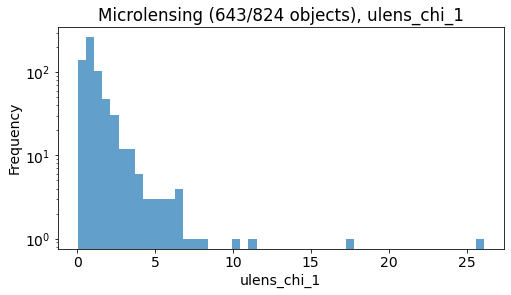

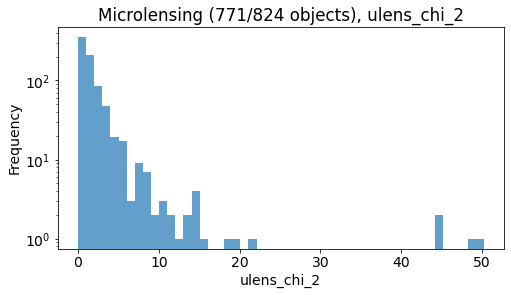

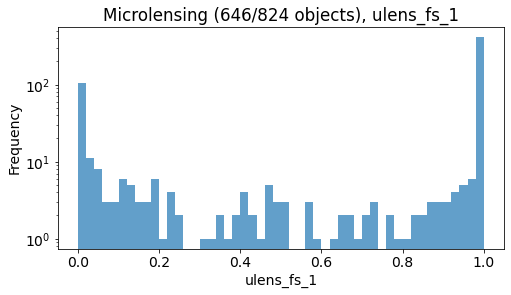

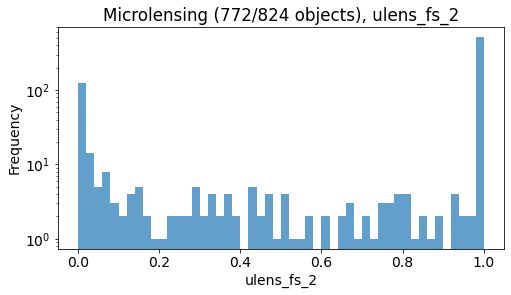

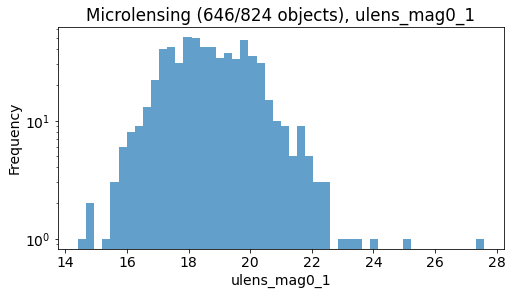

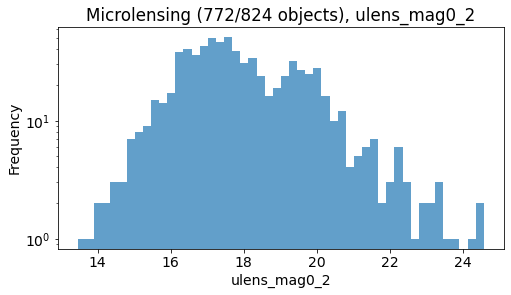

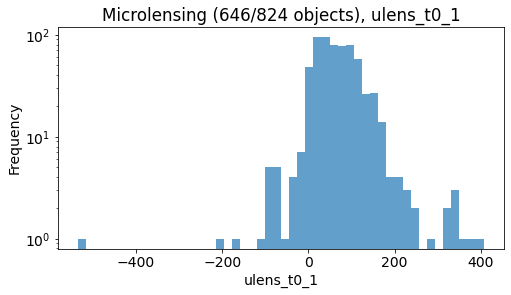

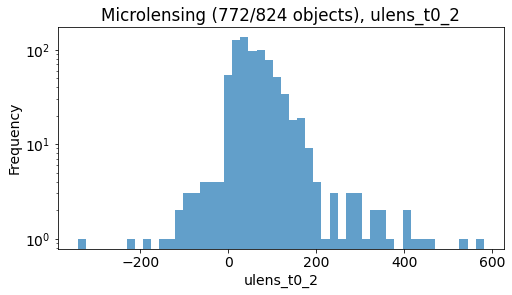

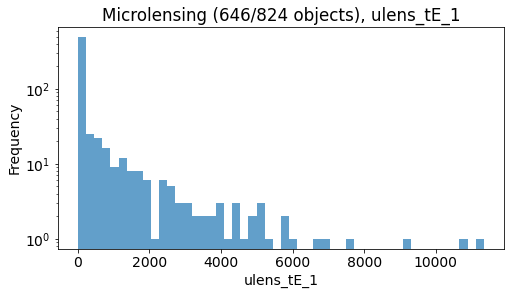

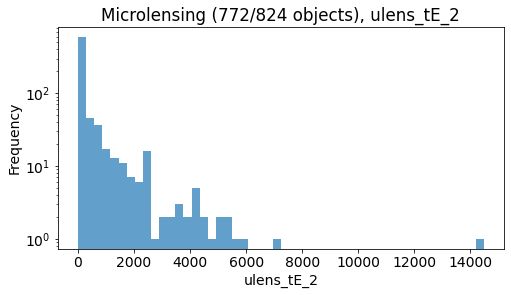

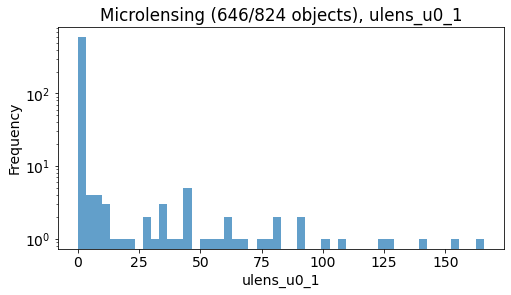

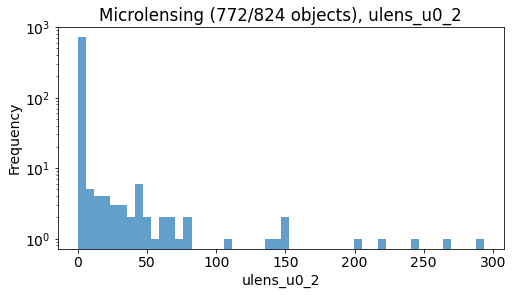

In [56]:
for prop in cols_ulens:
    mask = df_features[prop].notna() & np.isfinite(df_features[prop])
    df_aux = df_features[mask].copy()
    
    title = cl_this + ' (' + str(len(df_aux)) + '/' \
            + str(len(df_probs_r1_ulens)) + ' objects), ' + prop
    plot_cols_hist(df=df_aux, cols=[prop], bins=50,
                   title=title, fontsize=14)

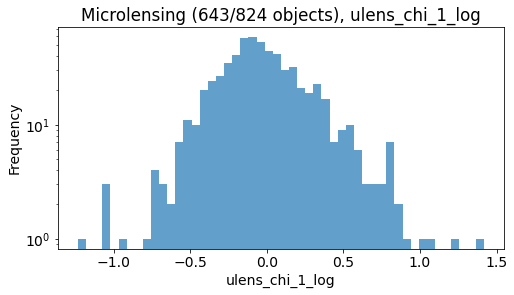

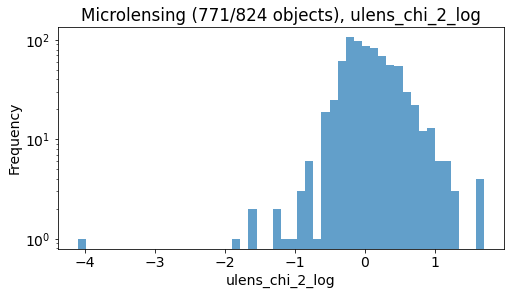

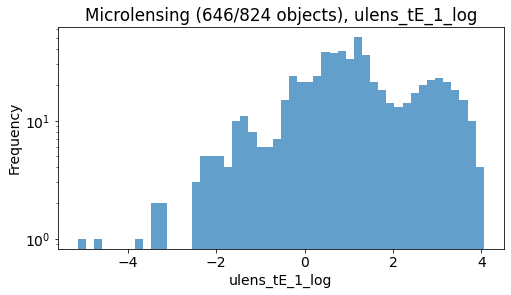

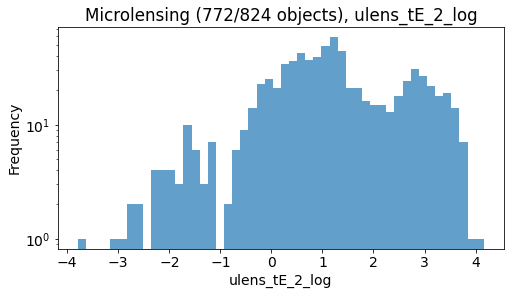

In [57]:
cols = ['ulens_chi_1', 'ulens_chi_2',
        'ulens_tE_1', 'ulens_tE_2']

df_aux = df_features[cols].copy()
for col in df_aux.columns:
    df_aux[col + '_log'] = np.log10(df_aux[col])
df_aux.drop(columns=cols, inplace=True)

for prop in df_aux.columns:
    mask = df_aux[prop].notna() & np.isfinite(df_aux[prop])
    df_aux2 = df_aux[mask].copy()
    
    title = cl_this + ' (' + str(len(df_aux2)) + '/' \
            + str(len(df_probs_r1_ulens)) + ' objects), ' + prop
    plot_cols_hist(df=df_aux2, cols=[prop], bins=50,
                   title=title, fontsize=14)

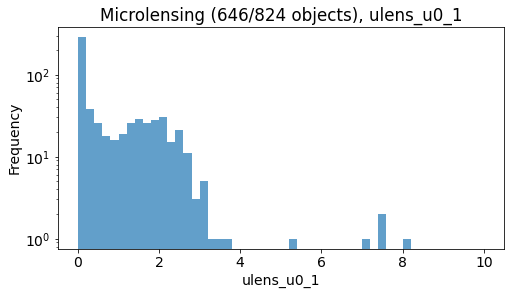

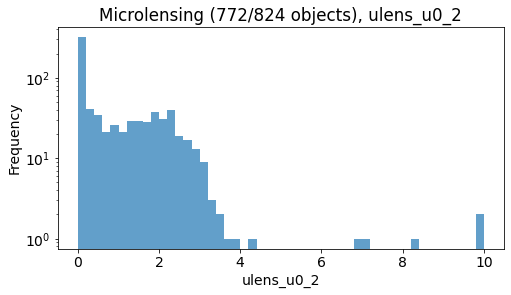

In [58]:
cols = ['ulens_u0_1', 'ulens_u0_2']

for prop in cols:
    mask = df_features[prop].notna() & np.isfinite(df_features[prop])
    df_aux = df_features[mask].copy()
    
    title = cl_this + ' (' + str(len(df_aux)) + '/' \
            + str(len(df_probs_r1_ulens)) + ' objects), ' + prop
    plot_cols_hist(df=df_aux, cols=[prop], bins=50, xlims=[0., 10.],
                   title=title, fontsize=14)

### Use custom cuts in features for refining your sample

In [59]:
mask = (df_features['ulens_u0_1'] < 1) \
        & (df_features['ulens_u0_2'] < 1) \
        & (df_features['ulens_chi_1'] < 1) \
        & (df_features['ulens_chi_2'] < 1) \
        & (df_features['ulens_tE_1'] > 10) \
        & (df_features['ulens_tE_2'] > 10) \
        & (df_features['ulens_tE_1'] < 1.5e2) \
        & (df_features['ulens_tE_2'] < 1.5e2)

mask2 = (df_features['ulens_u0_1'] < 1) \
        & df_features['ulens_u0_2'].isna() \
        & (df_features['ulens_chi_1'] < 1) \
        & df_features['ulens_chi_2'].isna() \
        & (df_features['ulens_tE_1'] > 10) \
        & df_features['ulens_tE_2'].isna() \
        & (df_features['ulens_tE_1'] < 1.55e2)

mask3 = (df_features['ulens_u0_2'] < 1) \
        & df_features['ulens_u0_1'].isna() \
        & (df_features['ulens_chi_2'] < 1) \
        & df_features['ulens_chi_1'].isna() \
        & (df_features['ulens_tE_2'] > 10) \
        & df_features['ulens_tE_1'].isna() \
        & (df_features['ulens_tE_2'] < 1.55e2)

df_features_sub = df_features[mask | mask2 | mask3].copy()
df_probs_r1_ulens_sub = df_probs_r1_ulens.loc[df_features_sub.index].copy()
df_probs_r1_ulens_sub.sort_values(by='probability', ascending=False, inplace=True)
df_features_sub = df_features_sub.loc[df_probs_r1_ulens_sub.index].copy()
print(str(len(df_features_sub)) + '/' \
      + str(len(df_probs_r1_ulens)) + ' objects')
print_link(index=df_probs_r1_ulens_sub.index[0:200], classifier='stamp_classifier')
display(df_probs_r1_ulens_sub)
display(df_features_sub[cols_ulens])

21/824 objects


,class_name,probability,ranking
oid,,,
ZTF25abccrvf,Microlensing,0.418176,1
ZTF25abbagas,Microlensing,0.382360,1
ZTF20abegywz,Microlensing,0.309996,1
ZTF25abbwpaj,Microlensing,0.270384,1
ZTF25aapycse,Microlensing,0.255600,1
ZTF20abbghpo,Microlensing,0.235944,1
ZTF20abehasm,Microlensing,0.228956,1
ZTF20abfvpqy,Microlensing,0.224640,1
ZTF20abbppvz,Microlensing,0.222528,1


fname,ulens_chi_1,ulens_chi_2,ulens_fs_1,ulens_fs_2,ulens_mag0_1,ulens_mag0_2,ulens_t0_1,ulens_t0_2,ulens_tE_1,ulens_tE_2,ulens_u0_1,ulens_u0_2
oid,,,,,,,,,,,,
ZTF25abccrvf,0.501802,0.833328,1.000000,0.938080,19.773781,17.721198,56.096881,55.172692,23.949738,25.778025,0.318485,6.644551e-07
ZTF25abbagas,0.721755,0.837965,1.000000,1.000000,20.915334,19.368372,38.917610,38.172162,25.151323,19.756073,0.273799,2.949228e-01
ZTF20abegywz,0.249715,0.449684,0.045148,1.000000,22.005916,19.197231,13.283318,26.560535,142.469590,65.957477,0.014206,3.700645e-01
ZTF25abbwpaj,NaN,0.267169,NaN,1.000000,NaN,19.919906,NaN,34.755647,NaN,12.386336,NaN,7.440812e-01
ZTF25aapycse,0.438078,NaN,1.000000,NaN,18.399917,NaN,17.263847,NaN,12.897609,NaN,0.337387,NaN
ZTF20abbghpo,NaN,0.987077,NaN,1.000000,NaN,18.597084,NaN,39.940184,NaN,23.178206,NaN,9.780925e-01
ZTF20abehasm,NaN,0.865554,NaN,0.201867,NaN,19.067929,NaN,27.889352,NaN,18.093202,NaN,4.598052e-01
ZTF20abfvpqy,NaN,0.378016,NaN,1.000000,NaN,21.219931,NaN,6.411459,NaN,135.572016,NaN,1.943366e-01
ZTF20abbppvz,NaN,0.591092,NaN,0.032713,NaN,20.557781,NaN,16.187665,NaN,11.962716,NaN,6.346920e-02


#### Display light curves for the 20 highest probability objects, along with their microlensing model fits

ZTF25abccrvf


21 detections
60 forced photometry epochs
ZTF25abbagas


10 detections
38 forced photometry epochs
ZTF20abegywz


24 detections
57 forced photometry epochs
ZTF25abbwpaj


10 detections
52 forced photometry epochs
ZTF25aapycse


16 detections
6 forced photometry epochs
ZTF20abbghpo


46 detections
88 forced photometry epochs
ZTF20abehasm


11 detections
57 forced photometry epochs
ZTF20abfvpqy


15 detections
29 forced photometry epochs
ZTF20abbppvz


8 detections
47 forced photometry epochs
ZTF25aaxxoqt


52 detections
42 forced photometry epochs
ZTF19abvbxbt


17 detections
88 forced photometry epochs
ZTF20abjspmr


/tmp/ipykernel_689290/1749020673.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10, 4))


26 detections
90 forced photometry epochs
ZTF20abefium


18 detections
62 forced photometry epochs
ZTF20adeihbq


11 detections
57 forced photometry epochs
ZTF20abwvbng


14 detections
65 forced photometry epochs
ZTF22absixbx


9 detections
10 forced photometry epochs
ZTF20abbgcnk


32 detections
87 forced photometry epochs
ZTF25abmpttq


9 detections
3 forced photometry epochs
ZTF20abmnqol


13 detections
72 forced photometry epochs
ZTF25aadimnc


11 detections
9 forced photometry epochs


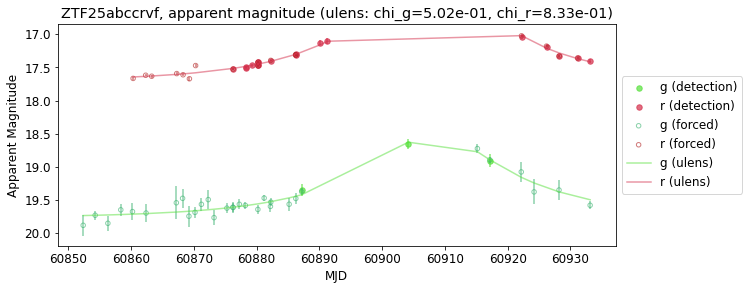

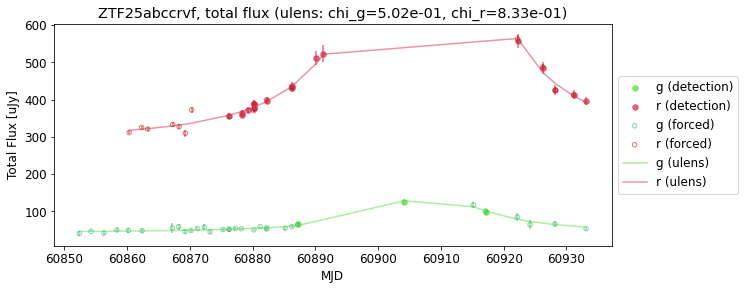

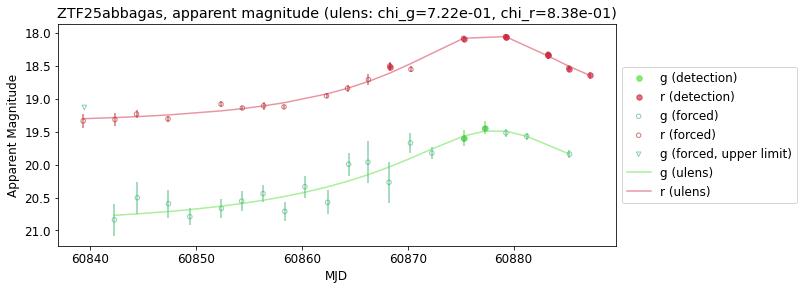

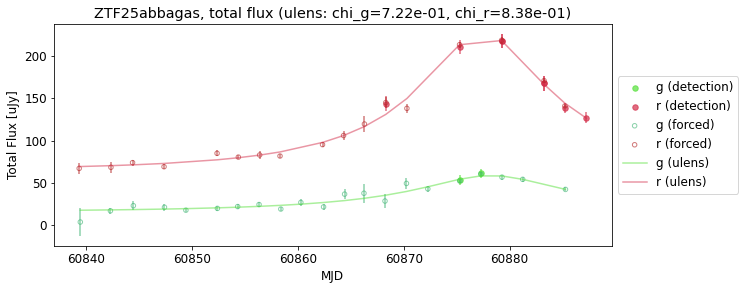

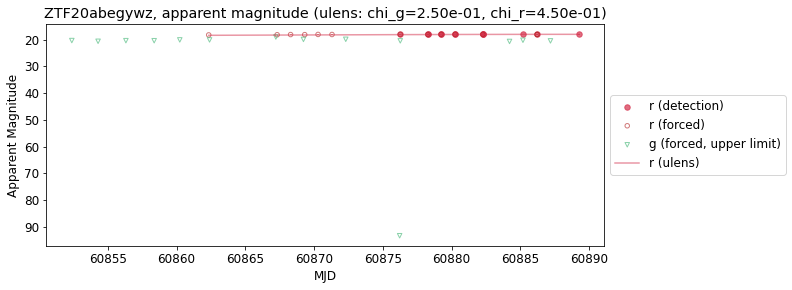

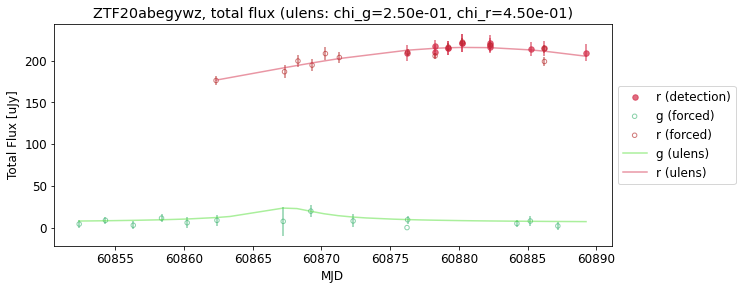

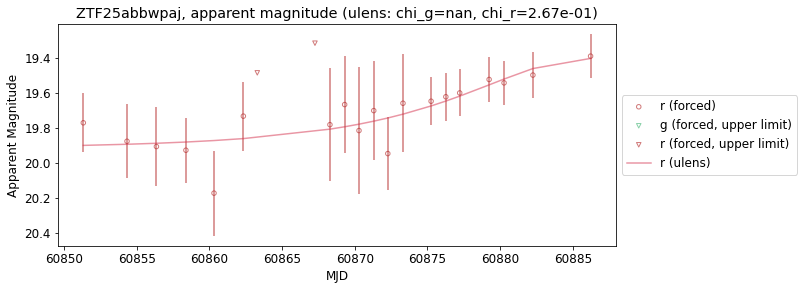

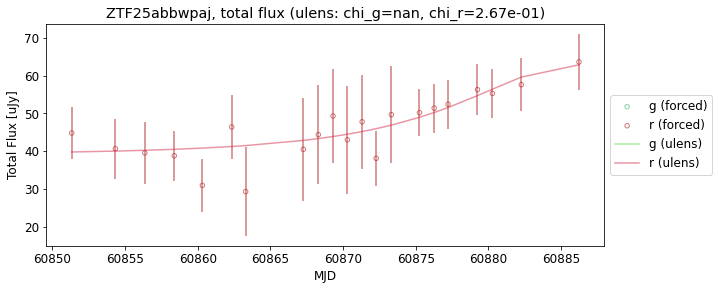

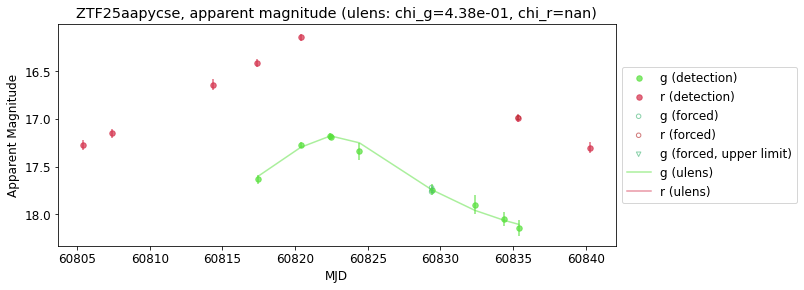

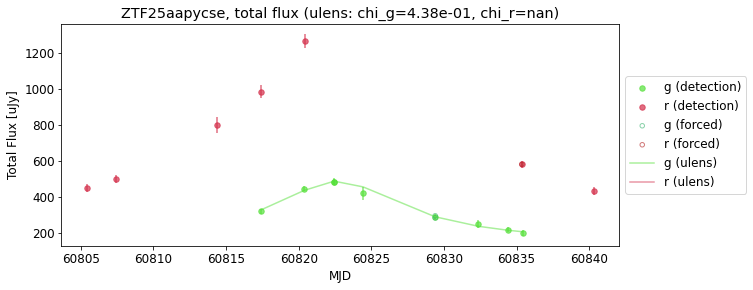

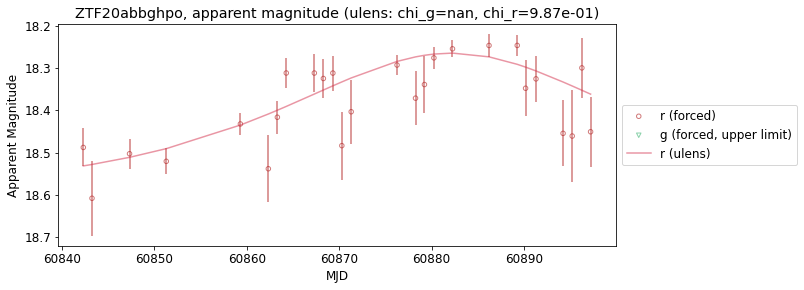

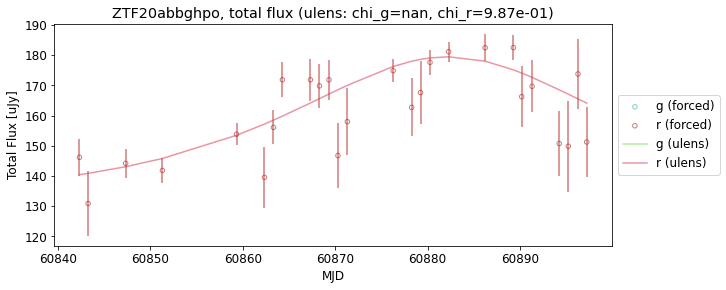

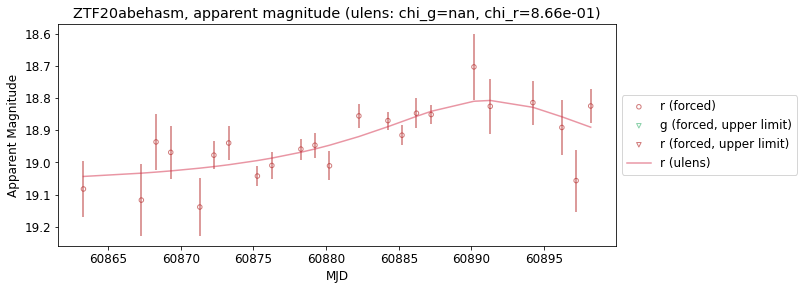

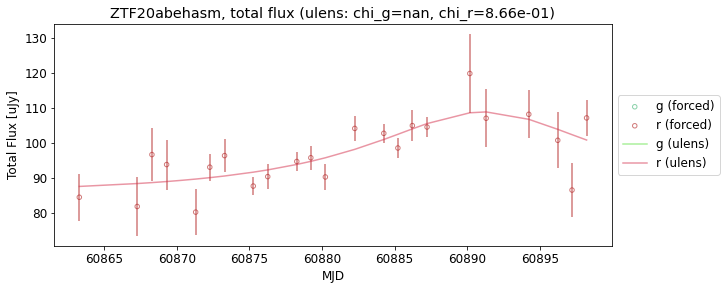

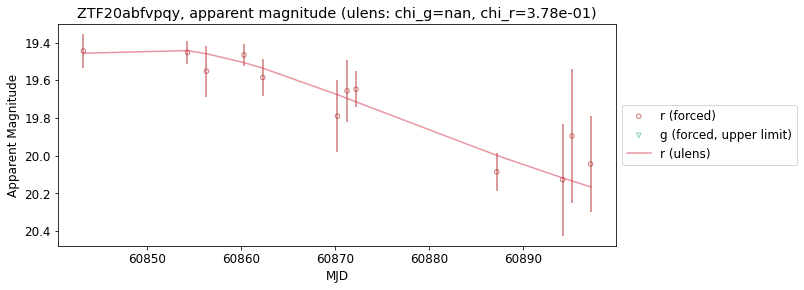

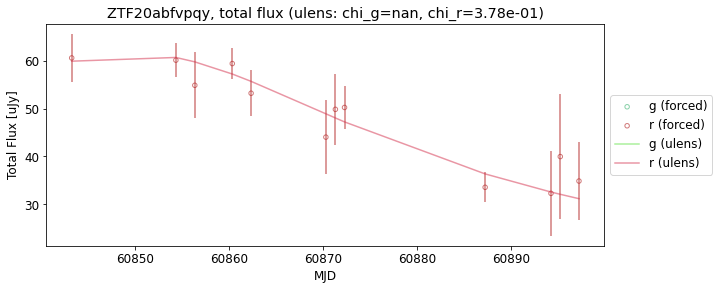

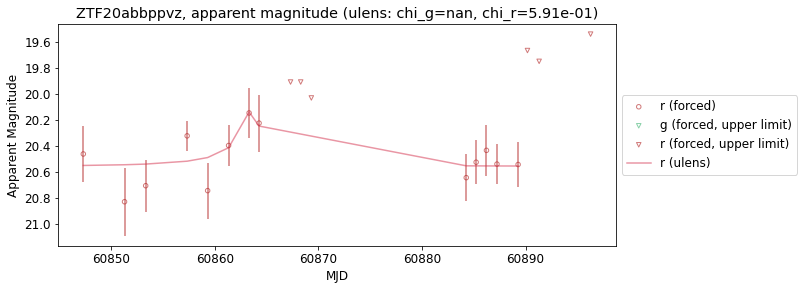

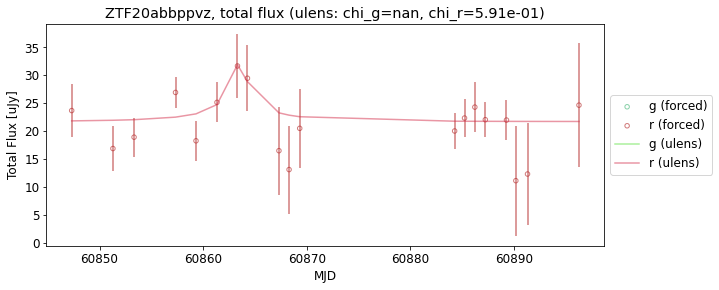

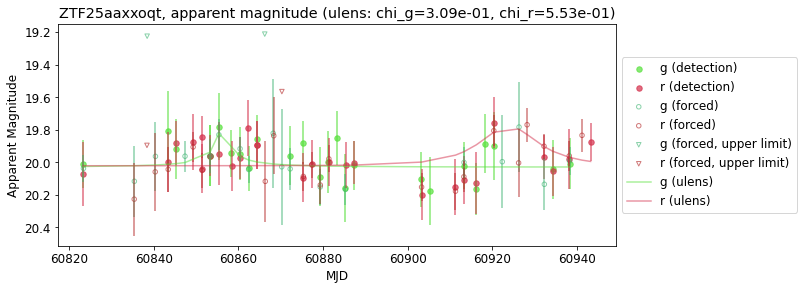

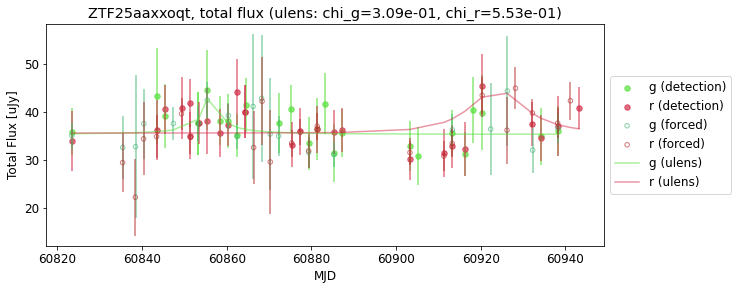

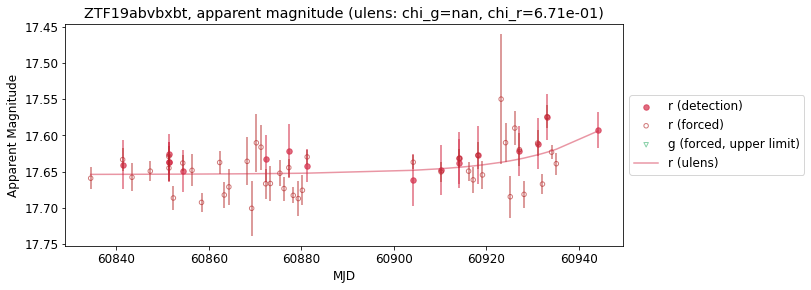

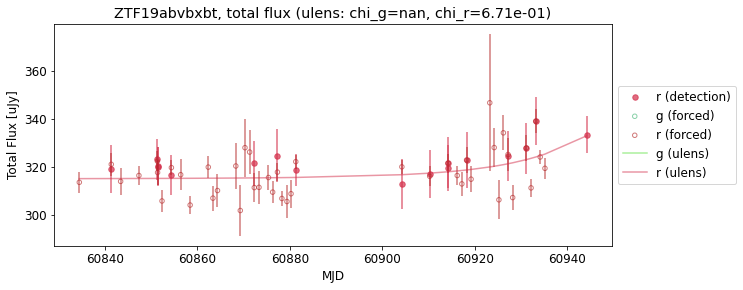

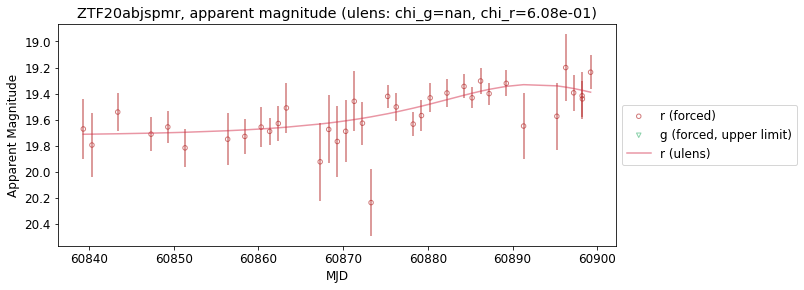

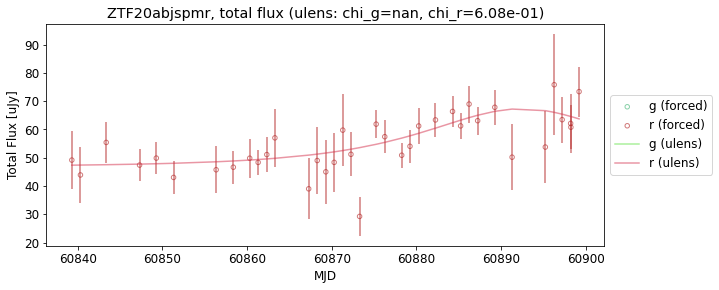

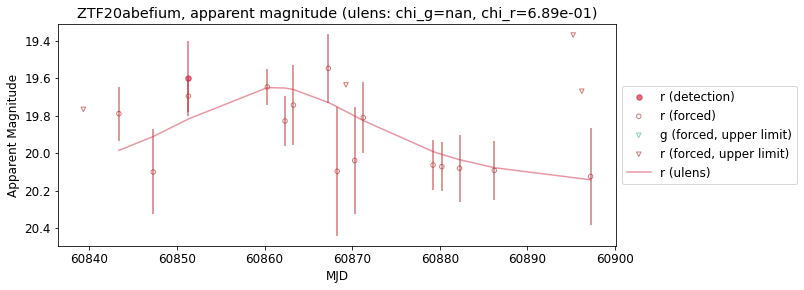

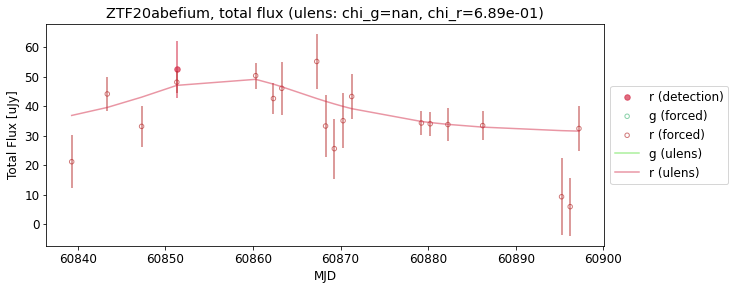

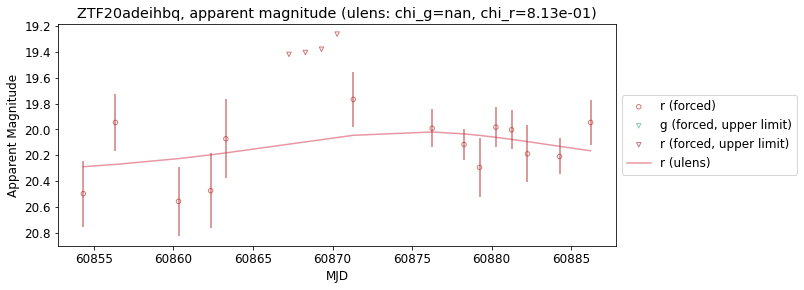

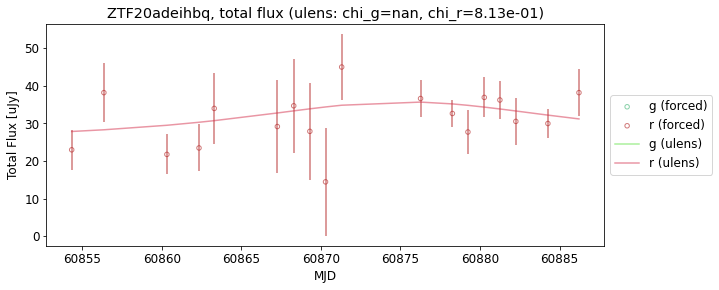

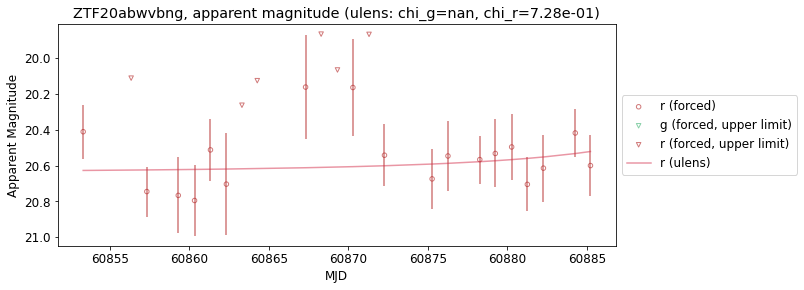

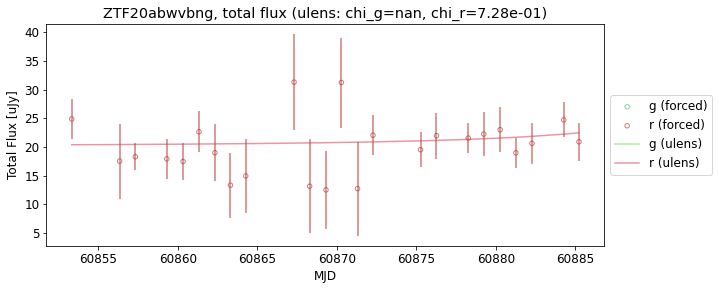

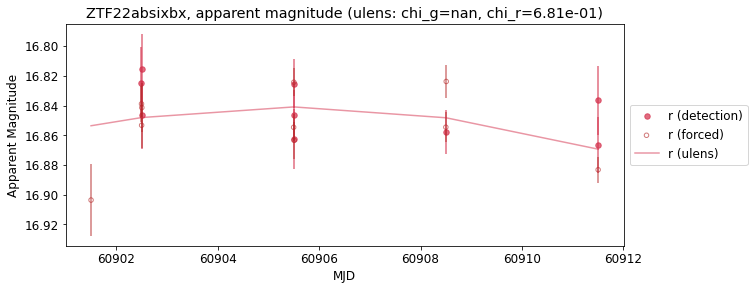

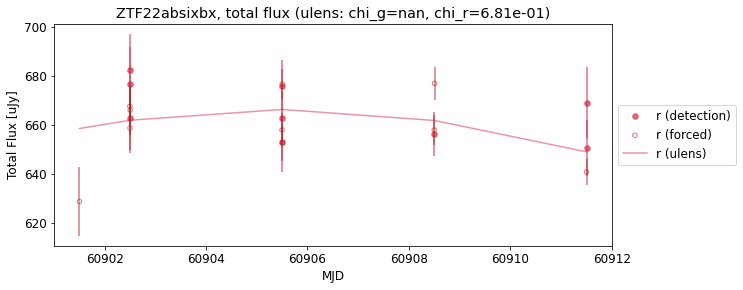

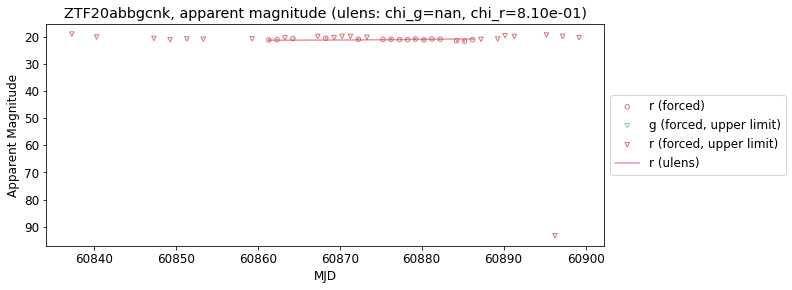

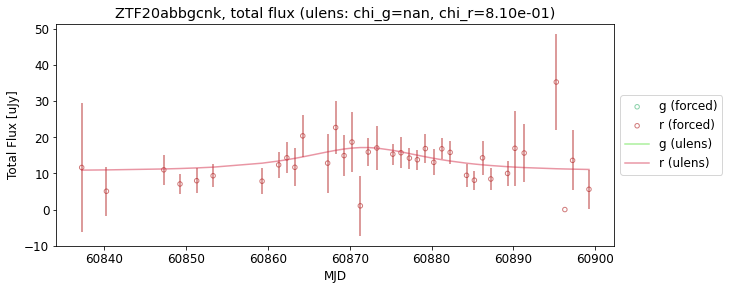

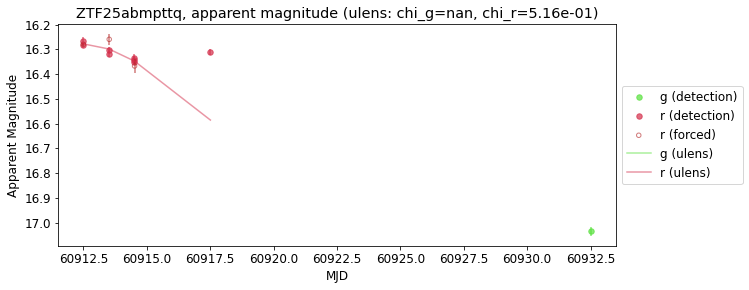

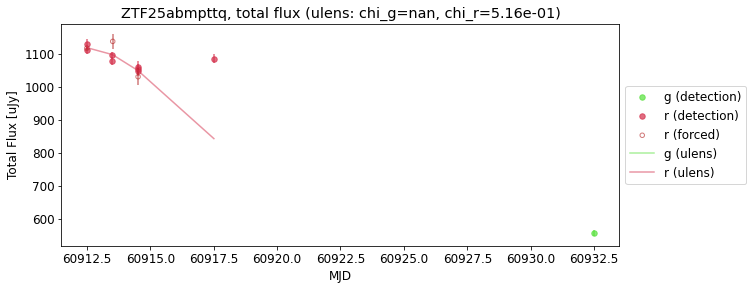

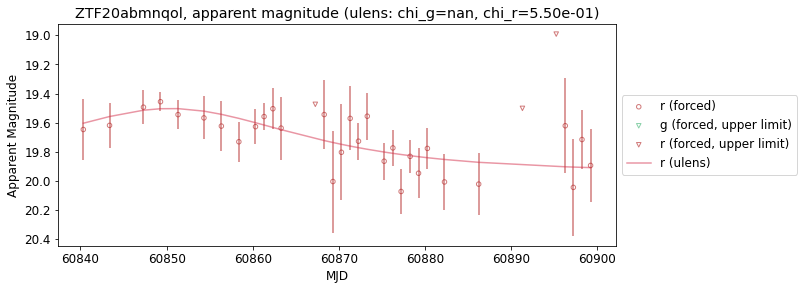

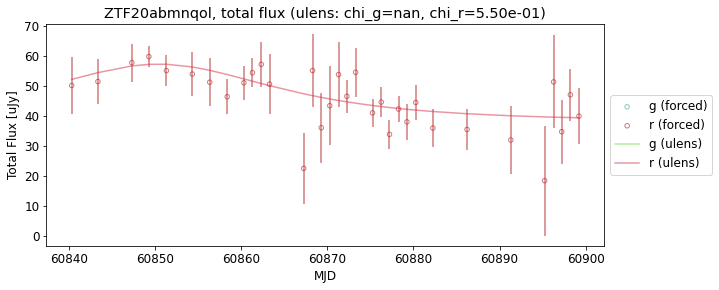

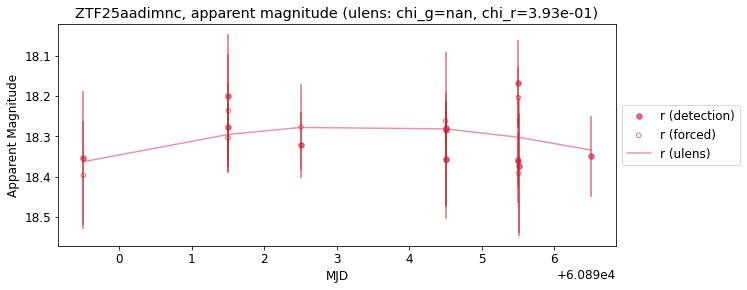

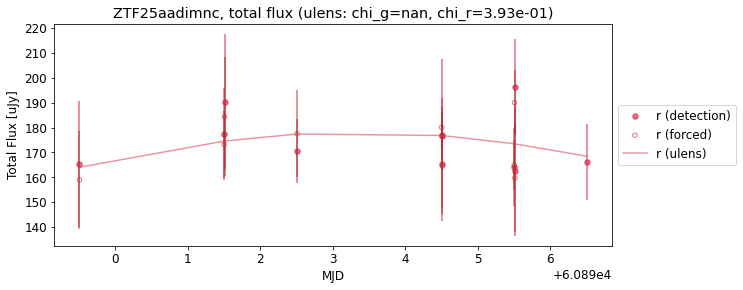

In [60]:
brightness_types = [
    'apparent magnitude',
    'total flux',
    #'difference magnitude',
    #'difference flux',
]

#oids = df_probs_r1_ulens_sub.index
oids = df_probs_r1_ulens_sub.index[0:20]

for oid in oids:
    plot_lc_oid(
        oid=oid,
        #show_params=True,
        #show_epochs=True,
        features=df_features,
        brightness_types=brightness_types,
    )

#### Query ranking=1 probabilities in LC_classifier_ATAT_forced_phot(beta) for recent objects (this classifier is currently in a beta stage, use with caution!)

In [61]:
i = 1
clf_name_beta = classifier_names[i]
clf_version_beta = classifier_versions[i]

In [62]:
print(clf_name_beta, clf_version_beta)

# Loop of queries
df_probs_r1_ulens_beta = query_probs_r1(chunk_size=10000,
                                        oids=df_recent.index,
                                        clf_name=clf_name_beta,
                                        clf_version=clf_version_beta,
                                        cl=cl_this)
df_probs_r1_ulens_beta.set_index('oid', inplace=True)
display(df_probs_r1_ulens_beta)

LC_classifier_ATAT_forced_phot(beta) 1.1.0_beta
4 chunks
Chunk 0
Chunk 1
Chunk 2
Chunk 3


,class_name,probability,ranking
oid,,,
ZTF18adjucld,Microlensing,0.874263,1
ZTF19aasivdx,Microlensing,0.372561,1
ZTF19abfkvar,Microlensing,0.688916,1
ZTF19abhfkyj,Microlensing,0.286112,1
ZTF19abijzoi,Microlensing,0.523738,1
...,...,...,...
ZTF25abonaap,Microlensing,0.925893,1
ZTF25abqgzqy,Microlensing,0.994804,1
ZTF25abqrxqb,Microlensing,0.682885,1


In [63]:
df_probs_r1_ulens_beta.sort_values(by='probability',
                                   ascending=False,
                                   inplace=True)

Show an ALeRCE Explorer link for these objects, sort by probability

In [64]:
print(clf_name_beta, clf_version_beta, cl_this)
print(str(len(df_probs_r1_ulens_beta)) + ' rows')

if len(df_probs_r1_ulens_beta) > 0:
    print_link(index=df_probs_r1_ulens_beta.iloc[0:200].index, classifier='stamp_classifier')
    display(df_probs_r1_ulens_beta)#.iloc[0:10])

LC_classifier_ATAT_forced_phot(beta) 1.1.0_beta Microlensing
161 rows


,class_name,probability,ranking
oid,,,
ZTF20aazwreq,Microlensing,0.999932,1
ZTF25aargdhd,Microlensing,0.999905,1
ZTF25abmhqso,Microlensing,0.998739,1
ZTF25aaoahhw,Microlensing,0.998389,1
ZTF25aaxjjub,Microlensing,0.998061,1
...,...,...,...
ZTF19abhfkyj,Microlensing,0.286112,1
ZTF23aapxpjn,Microlensing,0.281917,1
ZTF25aayfkkd,Microlensing,0.270062,1


#### Show distribution of probabilities

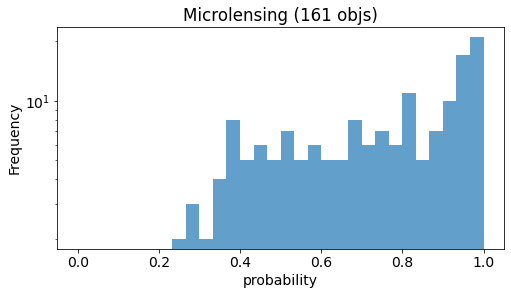

In [65]:
prop = 'probability'
title = cl_this + ' (' + str(len(df_probs_r1_ulens_beta)) + ' objs)'
plot_cols_hist(df=df_probs_r1_ulens_beta, cols=[prop], bins=30, xlims=[0., 1.],
               title=title, fontsize=14)

### Close the DB connection

In [66]:
conn.close()